In [21]:
# Importing all necessary packages 

import numpy as np
import pandas as pd
import seaborn as sns
import itertools  
from matplotlib import pyplot
%matplotlib inline

import missingno

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingRegressor

from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
    
import xgboost as xgb

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from scipy.special import boxcox,inv_boxcox

# Reading Datasets

In [22]:
train_file = pd.read_csv("/home/jiten/Desktop/ML Submissions/MachineHack/VideoGames/Data/Train.csv")

test_file = pd.read_csv("/home/jiten/Desktop/ML Submissions/MachineHack/VideoGames/Data/Test.csv")

In [23]:
len(train_file)

3506

In [24]:
len(test_file)

1503

In [25]:
train_file.describe()

,ID,YEAR,CRITICS_POINTS,USER_POINTS,SalesInMillions
count,3506.000000,3506.000000,3506.000000,3506.000000,3506.000000
mean,2282.233600,2008.990302,3.790831,0.405824,2.171021
std,1287.273422,4.304252,3.141781,0.455541,2.495396
min,1.000000,1997.000000,0.568966,0.000341,0.001524
25%,1220.250000,2006.000000,1.738095,0.065966,0.965679
50%,2262.500000,2009.000000,2.766667,0.233333,1.866140
75%,3404.750000,2012.000000,4.621528,0.598333,2.792029
max,4523.000000,2019.000000,23.250000,2.325000,84.226041


In [26]:
train_file.head()

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions
0,2860,ds,2008,role-playing,Nintendo,E,2.833333,0.303704,1.779257
1,731,wii,2012,simulation,Konami Digital Entertainment,E10+,13.200000,1.640000,0.215050
2,495,pc,2019,shooter,Activision,M,4.562500,0.006410,0.534402
3,2641,ps2,2002,sports,Electronic Arts,E,4.181818,0.326923,1.383964
4,811,ps3,2013,action,Activision,M,2.259259,0.032579,0.082671


In [27]:
train_df = train_file.copy()

test_df = test_file.copy()

train_df = train_df.drop_duplicates()

len(train_df)

3506

In [28]:
train_df.head()

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions
0,2860,ds,2008,role-playing,Nintendo,E,2.833333,0.303704,1.779257
1,731,wii,2012,simulation,Konami Digital Entertainment,E10+,13.200000,1.640000,0.215050
2,495,pc,2019,shooter,Activision,M,4.562500,0.006410,0.534402
3,2641,ps2,2002,sports,Electronic Arts,E,4.181818,0.326923,1.383964
4,811,ps3,2013,action,Activision,M,2.259259,0.032579,0.082671


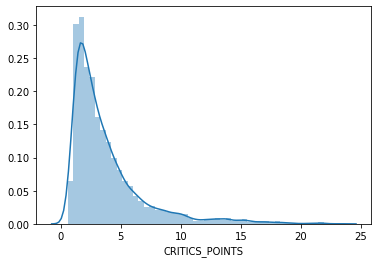

In [29]:
sns.distplot(train_file.CRITICS_POINTS)

In [30]:
test_df.head()

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS
0,4310,ps2,2008,action,Tecmo Koei,T,3.928571,0.482353
1,4011,psp,2007,strategy,Atari,E10+,5.538462,0.071795
2,2185,ps2,2004,shooter,Electronic Arts,T,3.034483,0.062044
3,1644,x,2006,action,Electronic Arts,E,2.913043,0.880000
4,188,3ds,2011,racing,Ubisoft,E10+,1.162162,0.183333


In [31]:
min(train_df.ID)

1

In [32]:
min(test_df.ID)

0

# Combining Train and Test sets for EDA 

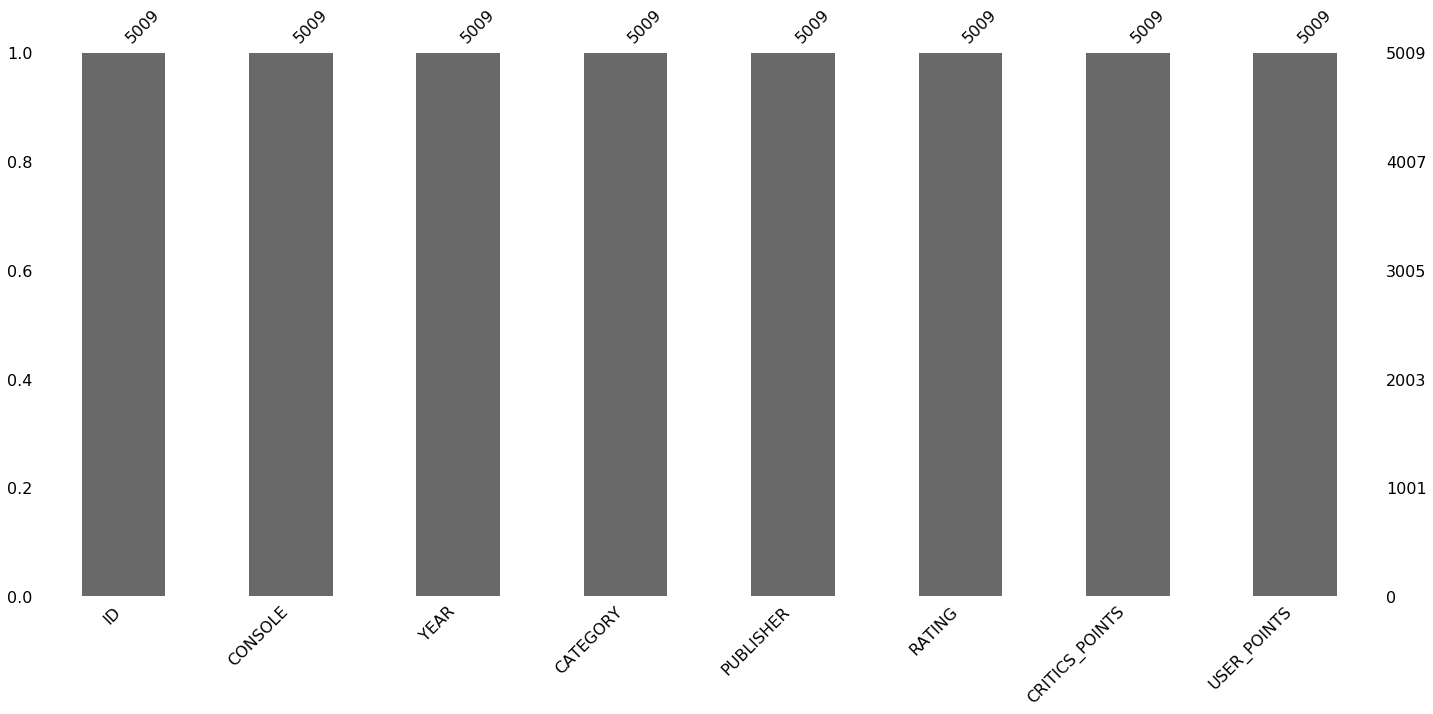

In [33]:
combine = pd.concat([train_df.drop("SalesInMillions",axis = 1),test_df])

missingno.bar(combine)

In [34]:
combine.skew()

ID               -0.025973
YEAR              0.060762
CRITICS_POINTS    2.299211
USER_POINTS       1.607630
dtype: float64

In [35]:
train_df.skew()

ID                 -0.010779
YEAR                0.117732
CRITICS_POINTS      2.277228
USER_POINTS         1.590871
SalesInMillions    13.477527
dtype: float64

# Univartiate Analysis of Features 

# Output Variable

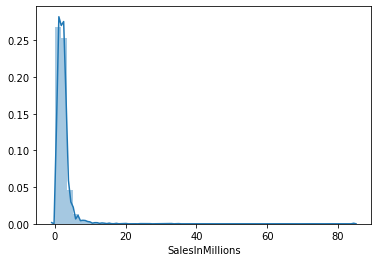

In [36]:
sns.distplot(train_df.SalesInMillions)

In [37]:
def modify_a_col(col,x):
        
    col = boxcox(col, x)
    
    print(col.skew())
    
    sns.distplot(col)

# Reduced Skewness of Output Variable by applying boxcox transformation

-0.0009362893164543252


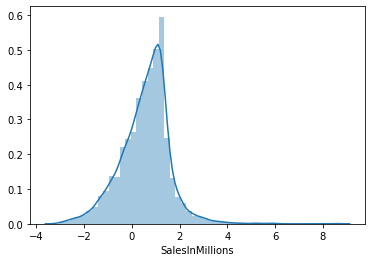

In [38]:
modify_a_col(train_df["SalesInMillions"],0.27)
    
train_df["SalesInMillions"] = boxcox(train_df["SalesInMillions"], 0.27)

# ID col cannot be ignored since it has repeated values 

In [39]:
train_file.columns

Index(['ID', 'CONSOLE', 'YEAR', 'CATEGORY', 'PUBLISHER', 'RATING',
       'CRITICS_POINTS', 'USER_POINTS', 'SalesInMillions'],
      dtype='object')

# CONSOLE COLUMN

In [42]:

if set(train_df.CONSOLE.unique()) == set(test_df.CONSOLE.unique()):
    
    print("All consoles are perfect !")


All consoles are perfect !


In [43]:
print(set(train_df.CONSOLE))

{'x360', 'psp', 'ps2', 'ds', 'gc', 'ps', 'wiiu', 'ps4', '3ds', 'dc', 'xone', 'x', 'psv', 'pc', 'gba', 'wii', 'ps3'}


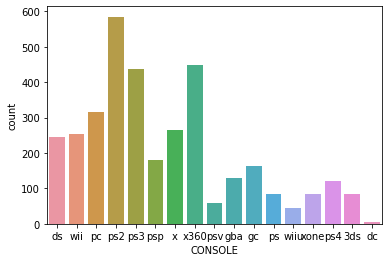

In [44]:
sns.countplot(train_df.CONSOLE)

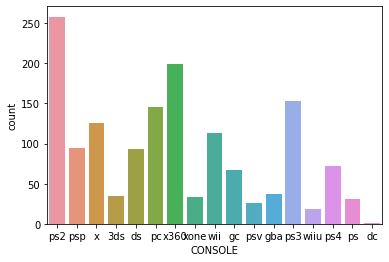

In [45]:
sns.countplot(test_df.CONSOLE)

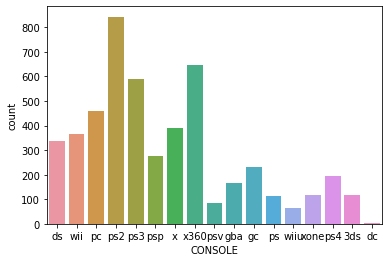

In [46]:
sns.countplot(combine.CONSOLE)

In [47]:
train_df.CONSOLE.value_counts()

ps2     585
x360    448
ps3     438
pc      315
x       266
wii     254
ds      246
psp     180
gc      164
gba     129
ps4     121
xone     85
3ds      84
ps       83
psv      59
wiiu     45
dc        4
Name: CONSOLE, dtype: int64

In [48]:
test_df.CONSOLE.value_counts()

ps2     258
x360    199
ps3     153
pc      146
x       125
wii     113
psp      94
ds       93
ps4      72
gc       67
gba      37
3ds      35
xone     34
ps       31
psv      26
wiiu     19
dc        1
Name: CONSOLE, dtype: int64

In [49]:
train_df.head()

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions
0,2860,ds,2008,role-playing,Nintendo,E,2.833333,0.303704,0.623434
1,731,wii,2012,simulation,Konami Digital Entertainment,E10+,13.200000,1.640000,-1.257900
2,495,pc,2019,shooter,Activision,M,4.562500,0.006410,-0.576469
3,2641,ps2,2002,sports,Electronic Arts,E,4.181818,0.326923,0.339633
4,811,ps3,2013,action,Activision,M,2.259259,0.032579,-1.814317


In [50]:
x = train_df.YEAR.unique()

print(list(set(x)))

[1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


In [51]:
y = test_df.YEAR.unique()

print(list(set(y)))

[1988, 1994, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


In [52]:
print(train_df.YEAR.unique().sort() == test_df.YEAR.unique().sort())

True


In [53]:
bins = [1950,2004, 2014,5000]

labels = ["age-1","age-2","age-3"]

 <= 2003, 2004 - 2013, >= 2014

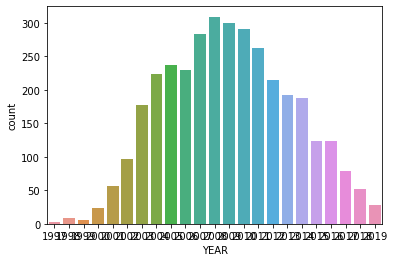

In [54]:
sns.countplot(train_df.YEAR)

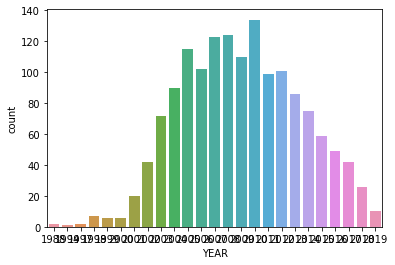

In [55]:
sns.countplot(test_df.YEAR)

# Binning Year Feature did not improve any accuracy

In [ ]:
# train_df["YEAR"] = pd.cut(train_df["YEAR"], bins=bins, labels=labels)
# test_df["YEAR"] = pd.cut(test_df["YEAR"], bins=bins, labels=labels)
# combine["YEAR"] = pd.cut(combine["YEAR"], bins=bins, labels=labels)



# No modifications were made to CATEGORY feature

In [63]:
train_df.head()

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions
0,2860,ds,2008,role-playing,Nintendo,E,2.833333,0.303704,0.623434
1,731,wii,2012,simulation,Konami Digital Entertainment,E10+,13.200000,1.640000,-1.257900
2,495,pc,2019,shooter,Activision,M,4.562500,0.006410,-0.576469
3,2641,ps2,2002,sports,Electronic Arts,E,4.181818,0.326923,0.339633
4,811,ps3,2013,action,Activision,M,2.259259,0.032579,-1.814317


In [65]:
print(train_df.CATEGORY.unique().sort() == test_df.CATEGORY.unique().sort())

True


In [66]:
len(set(train_df.CATEGORY))

12

In [67]:
set(train_df.CATEGORY)

{'action',
 'adventure',
 'fighting',
 'misc',
 'platform',
 'puzzle',
 'racing',
 'role-playing',
 'shooter',
 'simulation',
 'sports',
 'strategy'}

# No modifications were made to PUBLISHER feature

In [70]:
len(set(train_df.PUBLISHER))

204

In [71]:
set(train_df.PUBLISHER)

{'1C Company',
 '3Do',
 '505 Games',
 '506 Games',
 '5P',
 'Acclaim Entertainment',
 'Acquire',
 'Activision',
 'Activision Blizzard',
 'Agatsuma Entertainment',
 'Agetec',
 'Aksys Games',
 'Aq Interactive',
 'Aqua Plus',
 'Arc System Works',
 'Ascaron Entertainment Gmbh',
 'Ascii Entertainment',
 'Aspyr',
 'Atari',
 'Atlus',
 'Avalon Interactive',
 'Bam! Entertainment',
 'Banpresto',
 'Bethesda Softworks',
 'Bigben Interactive',
 'Bitcomposer Games',
 'Black Bean Games',
 'Black Label Games',
 'Blue Byte',
 'Capcom',
 'Cave',
 'Cdv Software Entertainment',
 'City Interactive',
 'Cloud Imperium Games Corporation',
 'Codemasters',
 'Compile Heart',
 'Crave Entertainment',
 'Crimson Cow',
 'D3Publisher',
 'Deep Silver',
 'Destination Software, Inc',
 'Destineer',
 'Devolver Digital',
 'Disney Interactive Studios',
 'Dreamcatcher Interactive',
 'Dtp Entertainment',
 'Dusenberry Martin Racing',
 'Ea Games',
 'Eidos Interactive',
 'Electronic Arts',
 'Empire Interactive',
 'En Masse Enterta

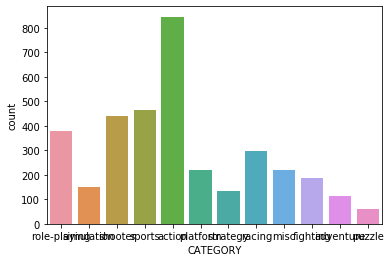

In [72]:
sns.countplot(train_df.CATEGORY)

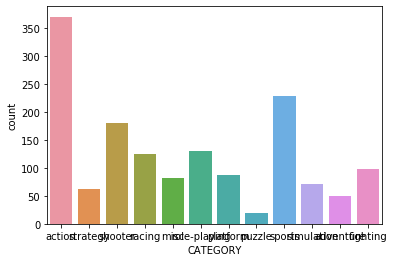

In [73]:
sns.countplot(test_df.CATEGORY)

In [74]:
train_df.head()

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions
0,2860,ds,2008,role-playing,Nintendo,E,2.833333,0.303704,0.623434
1,731,wii,2012,simulation,Konami Digital Entertainment,E10+,13.200000,1.640000,-1.257900
2,495,pc,2019,shooter,Activision,M,4.562500,0.006410,-0.576469
3,2641,ps2,2002,sports,Electronic Arts,E,4.181818,0.326923,0.339633
4,811,ps3,2013,action,Activision,M,2.259259,0.032579,-1.814317


# Both train and test sets contain same PUBLISHER values

In [76]:
if set(train_df.PUBLISHER.sort_values() == set(test_df.PUBLISHER.sort_values())):
    
    print(True)

True


In [77]:
len(set(train_df.PUBLISHER.sort_values()))

204

# RATING COLUMN 

some values present in train set which were absent in test set and hence they were dropped 

In [81]:
set(train_df.RATING.sort_values())

{'E', 'E10+', 'K-A', 'M', 'RP', 'T'}

In [82]:
set(test_df.RATING.sort_values())

{'AO', 'E', 'E10+', 'M', 'T'}

# Removing rows with "K-A" and "RP"

In [83]:
train_df[train_df.RATING == "K-A"]

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions
286,2771,ps,1998,misc,Sony Computer Entertainment,K-A,6.133333,0.154167,-0.147765


In [84]:
train_df[train_df.RATING == 'RP']

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions
374,3696,pc,2011,strategy,Paradox Interactive,RP,5.25,0.251852,1.121748
748,591,pc,2016,strategy,Gaslamp Games,RP,7.25,0.760000,-0.849052


In [85]:
test_df[test_df.RATING == "AO"]

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS
623,1543,x,2008,action,Take-Two Interactive,AO,1.603448,0.073109


In [86]:
train_df = train_df[(train_df.RATING != "RP") & (train_df.RATING != "K-A")]

In [88]:
set(train_df.RATING.sort_values())

{'E', 'E10+', 'M', 'T'}

In [89]:
train_df.head()

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions
0,2860,ds,2008,role-playing,Nintendo,E,2.833333,0.303704,0.623434
1,731,wii,2012,simulation,Konami Digital Entertainment,E10+,13.200000,1.640000,-1.257900
2,495,pc,2019,shooter,Activision,M,4.562500,0.006410,-0.576469
3,2641,ps2,2002,sports,Electronic Arts,E,4.181818,0.326923,0.339633
4,811,ps3,2013,action,Activision,M,2.259259,0.032579,-1.814317


In [90]:
combine.skew()

ID               -0.025973
YEAR              0.060762
CRITICS_POINTS    2.299211
USER_POINTS       1.607630
dtype: float64

# Reduced skewness of  CRITICS POINTS by applying boxcox transformation

0.030325075809584566


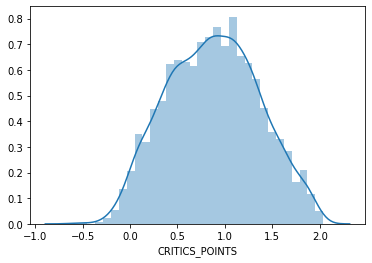

In [91]:
modify_a_col(combine.CRITICS_POINTS,-0.3)

train_df["CRITICS_POINTS"] = boxcox(train_df["CRITICS_POINTS"], -0.3)

test_df["CRITICS_POINTS"] = boxcox(test_df["CRITICS_POINTS"], -0.3)

# Reduced skewness of  USER POINTS by applying boxcox transformation

0.024270050203997705


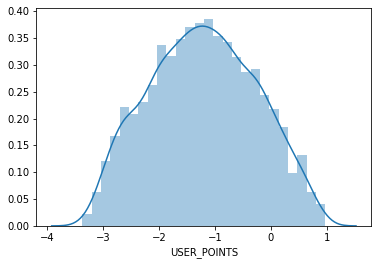

In [92]:
modify_a_col(combine.USER_POINTS,0.26)

train_df["USER_POINTS"] = boxcox(train_df["USER_POINTS"], 0.26)

test_df["USER_POINTS"] = boxcox(test_df["USER_POINTS"], 0.26)

In [93]:
train_df.RATING.unique()

array(['E', 'E10+', 'M', 'T'], dtype=object)

In [94]:
rating_dict = {
    "E" : 1,
    "E10+" : 5,
    "M" : 10,
    "T" : 15
}

# train_df["RATING"] = train_df["RATING"].map(rating_dict)
# test_df["RATING"] = test_df["RATING"].map(rating_dict)
# combine["RATING"] = combine["RATING"].map(rating_dict)

# I tried Feature Engineering but that decreased model accuracy

In [97]:
# train_df["Skills"] = inv_boxcox(train_df.USER_POINTS,0.26) * train_df.RATING

# test_df["Skills"] = inv_boxcox(test_df.USER_POINTS, 0.26) * test_df.RATING

# test_df["Skills"] = test_df["Skills"].fillna(np.mean(train_df.Skills))
        
# combine["Skills"] = inv_boxcox(combine.USER_POINTS, 0.26) * combine.RATING

# combine["Skills"] = combine["Skills"].fillna(np.mean(train_df.Skills))

# train_df["Skills"] = boxcox(train_df.Skills, 0.20)
# test_df["Skills"] = boxcox(test_df.Skills, 0.20)
# combine["Skills"] = boxcox(combine.Skills, 0.20)

In [98]:
train_df.skew()

ID                -0.010394
YEAR               0.121266
CRITICS_POINTS     0.018155
USER_POINTS        0.018782
SalesInMillions   -0.001442
dtype: float64

In [99]:
# modify_a_col(train_df.Skills, 0.20)

In [100]:
print(test_df.CONSOLE.unique())

['ps2' 'psp' 'x' '3ds' 'ds' 'pc' 'x360' 'xone' 'wii' 'gc' 'psv' 'gba'
 'ps3' 'wiiu' 'ps4' 'ps' 'dc']


In [101]:
len(train_df.CONSOLE.unique())

17

In [102]:
print(train_df.CONSOLE.unique())

['ds' 'wii' 'pc' 'ps2' 'ps3' 'psp' 'x' 'x360' 'psv' 'gba' 'gc' 'ps' 'wiiu'
 'xone' 'ps4' '3ds' 'dc']


In [65]:
console_dict = {
    
    "x" : "x-type",
    "xone" : "x-type",
    "x360" : "x-type",
    "psp" : "p-type",
    "ps2" : "p-type",
    "ps3" : "p-type",
    "ps4" : "p-type",
    "ps"  : "p-type",
    "psv" : "p-type",
    "pc" : "pc",
    "wii" : "w-type",
    "wiiu" : "w-type",
    "ds"  : "d-type",
    "3ds" : "d-type",
    "dc" : "d-type",
    "gba" : "g-type",
    "gc" : "g-type",
}

print(len(console_dict.keys()))

print(set(console_dict.keys()) == set(train_df.CONSOLE.unique()))

# train_df["CONSOLE"] = train_df.CONSOLE.map(console_dict)
# test_df["CONSOLE"] = test_df.CONSOLE.map(console_dict)
# combine["CONSOLE"] = combine.CONSOLE.map(console_dict)

17
True


In [66]:
# train_df["How_much_Old"] = train_df["YEAR"].apply(lambda x : 2020 - x)
# test_df["How_much_Old"] = test_df["YEAR"].apply(lambda x : 2020 - x)
# combine["How_much_Old"] = combine["YEAR"].apply(lambda x : 2020 - x)

# train_df = train_df.drop("YEAR",axis = 1)
# test_df = test_df.drop("YEAR",axis = 1)
# combine = combine.drop("YEAR",axis = 1)



In [103]:
def move_target_to_last(dataset, col_name):
    
    x = dataset[col_name]
    
    dataset = dataset.drop(col_name, axis = 1)
    
    dataset[col_name] = x
    
    return dataset

In [104]:
train_df = move_target_to_last(train_df, "SalesInMillions")

In [105]:
train_df.head()

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions
0,2860,ds,2008,role-playing,Nintendo,E,0.894459,-1.024760,0.623434
1,731,wii,2012,simulation,Konami Digital Entertainment,E10+,1.796218,0.527919,-1.257900
2,495,pc,2019,shooter,Activision,M,1.219271,-2.811454,-0.576469
3,2641,ps2,2002,sports,Electronic Arts,E,1.163286,-0.970196,0.339633
4,811,ps3,2013,action,Activision,M,0.723042,-2.267121,-1.814317


In [106]:
test_df.head()

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS
0,4310,ps2,2008,action,Tecmo Koei,T,1.122234,-0.664144
1,4011,psp,2007,strategy,Atari,E10+,1.338705,-1.907006
2,2185,ps2,2004,shooter,Electronic Arts,T,0.944129,-1.979223
3,1644,x,2006,action,Electronic Arts,E,0.914674,-0.125732
4,188,3ds,2011,racing,Ubisoft,E10+,0.146945,-1.371757


In [107]:
train_df.corr()

,ID,YEAR,CRITICS_POINTS,USER_POINTS,SalesInMillions
ID,1.000000,-0.052969,0.007047,0.061334,-0.032628
YEAR,-0.052969,1.000000,-0.181344,-0.415385,0.004861
CRITICS_POINTS,0.007047,-0.181344,1.000000,0.521520,-0.119885
USER_POINTS,0.061334,-0.415385,0.521520,1.000000,-0.205847
SalesInMillions,-0.032628,0.004861,-0.119885,-0.205847,1.000000


In [108]:
new_train = train_df.copy()

new_test = test_df.copy()

new_train = new_train.drop("CRITICS_POINTS",axis = 1)

new_test = new_test.drop("CRITICS_POINTS", axis = 1)

In [109]:
train_df.head()

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions
0,2860,ds,2008,role-playing,Nintendo,E,0.894459,-1.024760,0.623434
1,731,wii,2012,simulation,Konami Digital Entertainment,E10+,1.796218,0.527919,-1.257900
2,495,pc,2019,shooter,Activision,M,1.219271,-2.811454,-0.576469
3,2641,ps2,2002,sports,Electronic Arts,E,1.163286,-0.970196,0.339633
4,811,ps3,2013,action,Activision,M,0.723042,-2.267121,-1.814317


In [110]:
class Jiten(object):
    def get_final_error(self, error, weight):
        return np.sqrt(boxcox(error,0.27) / (weight + 1e-38))

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += inv_boxcox(w,0.27) * ((inv_boxcox(approx[i],0.27) - inv_boxcox(target[i],0.27))**2)

        return error_sum, weight_sum

Since we have transformed output variable we need to change eval metric so that catboost model performance increase 

Model score increased from 1.66 to 1.62 without any tuning 

In [111]:
# class RmseObjective(object):
#     def calc_ders_range(self, approxes, targets, weights):
#         assert len(approxes) == len(targets)
#         if weights is not None:
#             assert len(weights) == len(approxes)
        
#         targets = inv_boxcox(targets, 0.27)
        
#         approxes = inv_boxcox(approxes, 0.27)
        
#         result = []
        
#         for index in range(len(targets)):
#             der1 = targets[index] - approxes[index]
#             der2 = -1

#             if weights is not None:
#                 der1 *= weights[index]
#                 der2 *= weights[index]

#             result.append((der1, der2))
#         return result

Getting Validation Test

In [112]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(["SalesInMillions"],axis = 1), train_df["SalesInMillions"], test_size = 0.2,random_state=8)

In [113]:
cat_columns=train_df.select_dtypes(include=['object','category']).columns.tolist()

cat_columns

['CONSOLE', 'CATEGORY', 'PUBLISHER', 'RATING']

# Model Training

In [114]:
model = CatBoostRegressor(use_best_model=True,learning_rate=0.01,n_estimators=10000,objective="RMSE",cat_features=cat_columns,eval_metric=Jiten())

In [166]:
model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1539918	test: 0.2422258	best: 0.2422258 (0)	total: 57ms	remaining: 9m 30s
1:	learn: 0.1538974	test: 0.2420042	best: 0.2420042 (1)	total: 111ms	remaining: 9m 17s
2:	learn: 0.1537630	test: 0.2417748	best: 0.2417748 (2)	total: 168ms	remaining: 9m 20s
3:	learn: 0.1536088	test: 0.2415686	best: 0.2415686 (3)	total: 223ms	remaining: 9m 17s
4:	learn: 0.1534380	test: 0.2413260	best: 0.2413260 (4)	total: 290ms	remaining: 9m 38s
5:	learn: 0.1533625	test: 0.2411649	best: 0.2411649 (5)	total: 343ms	remaining: 9m 32s
6:	learn: 0.1531989	test: 0.2409266	best: 0.2409266 (6)	total: 447ms	remaining: 10m 38s
7:	learn: 0.1530373	test: 0.2407452	best: 0.2407452 (7)	total: 560ms	remaining: 11m 39s
8:	learn: 0.1528466	test: 0.2404252	best: 0.2404252 (8)	total: 639ms	remaining: 11m 49s
9:	learn: 0.1527498	test: 0.2401880	best: 0.2401880 (9)	total: 680ms	remaining: 11m 19s
10:	learn: 0.1525578	test: 0.2399246	best: 0.2399246 (10)	total: 722ms	remaining: 10m 55s
11:	learn: 0.1523541	test: 0.2397129	

95:	learn: 0.1349119	test: 0.2247413	best: 0.2247413 (95)	total: 5.42s	remaining: 9m 19s
96:	learn: 0.1348454	test: 0.2246518	best: 0.2246518 (96)	total: 5.5s	remaining: 9m 21s
97:	learn: 0.1347807	test: 0.2245402	best: 0.2245402 (97)	total: 5.58s	remaining: 9m 23s
98:	learn: 0.1347359	test: 0.2244967	best: 0.2244967 (98)	total: 5.62s	remaining: 9m 22s
99:	learn: 0.1346463	test: 0.2243694	best: 0.2243694 (99)	total: 5.67s	remaining: 9m 21s
100:	learn: 0.1344336	test: 0.2243390	best: 0.2243390 (100)	total: 5.72s	remaining: 9m 20s
101:	learn: 0.1342662	test: 0.2242140	best: 0.2242140 (101)	total: 5.77s	remaining: 9m 19s
102:	learn: 0.1340684	test: 0.2240659	best: 0.2240659 (102)	total: 5.84s	remaining: 9m 21s
103:	learn: 0.1337900	test: 0.2238695	best: 0.2238695 (103)	total: 5.9s	remaining: 9m 21s
104:	learn: 0.1336508	test: 0.2237599	best: 0.2237599 (104)	total: 5.95s	remaining: 9m 20s
105:	learn: 0.1335814	test: 0.2236795	best: 0.2236795 (105)	total: 5.99s	remaining: 9m 19s
106:	learn:

187:	learn: 0.1270609	test: 0.2201267	best: 0.2201242 (186)	total: 10.5s	remaining: 9m 5s
188:	learn: 0.1270278	test: 0.2201168	best: 0.2201168 (188)	total: 10.5s	remaining: 9m 5s
189:	learn: 0.1269624	test: 0.2201074	best: 0.2201074 (189)	total: 10.6s	remaining: 9m 5s
190:	learn: 0.1268800	test: 0.2201284	best: 0.2201074 (189)	total: 10.6s	remaining: 9m 4s
191:	learn: 0.1268580	test: 0.2200769	best: 0.2200769 (191)	total: 10.6s	remaining: 9m 3s
192:	learn: 0.1267869	test: 0.2199718	best: 0.2199718 (192)	total: 10.7s	remaining: 9m 4s
193:	learn: 0.1267843	test: 0.2199704	best: 0.2199704 (193)	total: 10.8s	remaining: 9m 4s
194:	learn: 0.1267383	test: 0.2199614	best: 0.2199614 (194)	total: 10.8s	remaining: 9m 4s
195:	learn: 0.1266916	test: 0.2199346	best: 0.2199346 (195)	total: 10.9s	remaining: 9m 4s
196:	learn: 0.1266217	test: 0.2199965	best: 0.2199346 (195)	total: 10.9s	remaining: 9m 3s
197:	learn: 0.1265956	test: 0.2199655	best: 0.2199346 (195)	total: 11s	remaining: 9m 3s
198:	learn: 

278:	learn: 0.1247128	test: 0.2189639	best: 0.2189639 (278)	total: 15.3s	remaining: 8m 53s
279:	learn: 0.1246856	test: 0.2189522	best: 0.2189522 (279)	total: 15.4s	remaining: 8m 53s
280:	learn: 0.1246704	test: 0.2189619	best: 0.2189522 (279)	total: 15.4s	remaining: 8m 53s
281:	learn: 0.1246576	test: 0.2189075	best: 0.2189075 (281)	total: 15.5s	remaining: 8m 53s
282:	learn: 0.1246452	test: 0.2189081	best: 0.2189075 (281)	total: 15.5s	remaining: 8m 53s
283:	learn: 0.1246339	test: 0.2189032	best: 0.2189032 (283)	total: 15.6s	remaining: 8m 53s
284:	learn: 0.1246253	test: 0.2188992	best: 0.2188992 (284)	total: 15.7s	remaining: 8m 53s
285:	learn: 0.1246068	test: 0.2188539	best: 0.2188539 (285)	total: 15.7s	remaining: 8m 53s
286:	learn: 0.1245878	test: 0.2188377	best: 0.2188377 (286)	total: 15.8s	remaining: 8m 53s
287:	learn: 0.1245701	test: 0.2187562	best: 0.2187562 (287)	total: 15.9s	remaining: 8m 54s
288:	learn: 0.1245622	test: 0.2187587	best: 0.2187562 (287)	total: 15.9s	remaining: 8m 54s

371:	learn: 0.1233465	test: 0.2184861	best: 0.2184561 (356)	total: 20.1s	remaining: 8m 40s
372:	learn: 0.1233243	test: 0.2184939	best: 0.2184561 (356)	total: 20.2s	remaining: 8m 40s
373:	learn: 0.1233202	test: 0.2184910	best: 0.2184561 (356)	total: 20.2s	remaining: 8m 40s
374:	learn: 0.1232984	test: 0.2184962	best: 0.2184561 (356)	total: 20.2s	remaining: 8m 39s
375:	learn: 0.1232946	test: 0.2184929	best: 0.2184561 (356)	total: 20.3s	remaining: 8m 39s
376:	learn: 0.1232779	test: 0.2184921	best: 0.2184561 (356)	total: 20.3s	remaining: 8m 39s
377:	learn: 0.1232718	test: 0.2184645	best: 0.2184561 (356)	total: 20.4s	remaining: 8m 38s
378:	learn: 0.1232181	test: 0.2184572	best: 0.2184561 (356)	total: 20.4s	remaining: 8m 38s
379:	learn: 0.1232073	test: 0.2184550	best: 0.2184550 (379)	total: 20.5s	remaining: 8m 38s
380:	learn: 0.1231972	test: 0.2184353	best: 0.2184353 (380)	total: 20.5s	remaining: 8m 38s
381:	learn: 0.1231943	test: 0.2184366	best: 0.2184353 (380)	total: 20.6s	remaining: 8m 38s

462:	learn: 0.1219824	test: 0.2179569	best: 0.2179569 (462)	total: 24.6s	remaining: 8m 25s
463:	learn: 0.1219801	test: 0.2179543	best: 0.2179543 (463)	total: 24.6s	remaining: 8m 26s
464:	learn: 0.1219711	test: 0.2179496	best: 0.2179496 (464)	total: 24.7s	remaining: 8m 25s
465:	learn: 0.1219645	test: 0.2179522	best: 0.2179496 (464)	total: 24.7s	remaining: 8m 25s
466:	learn: 0.1219623	test: 0.2179524	best: 0.2179496 (464)	total: 24.8s	remaining: 8m 25s
467:	learn: 0.1219388	test: 0.2179229	best: 0.2179229 (467)	total: 24.8s	remaining: 8m 25s
468:	learn: 0.1219335	test: 0.2179216	best: 0.2179216 (468)	total: 24.9s	remaining: 8m 25s
469:	learn: 0.1219299	test: 0.2179194	best: 0.2179194 (469)	total: 24.9s	remaining: 8m 25s
470:	learn: 0.1219137	test: 0.2179201	best: 0.2179194 (469)	total: 25s	remaining: 8m 24s
471:	learn: 0.1219072	test: 0.2179119	best: 0.2179119 (471)	total: 25s	remaining: 8m 24s
472:	learn: 0.1219000	test: 0.2179105	best: 0.2179105 (472)	total: 25s	remaining: 8m 24s
473:	

557:	learn: 0.1210705	test: 0.2176702	best: 0.2176635 (551)	total: 29.1s	remaining: 8m 12s
558:	learn: 0.1210561	test: 0.2176712	best: 0.2176635 (551)	total: 29.2s	remaining: 8m 12s
559:	learn: 0.1210492	test: 0.2176709	best: 0.2176635 (551)	total: 29.2s	remaining: 8m 12s
560:	learn: 0.1210441	test: 0.2176709	best: 0.2176635 (551)	total: 29.3s	remaining: 8m 12s
561:	learn: 0.1210219	test: 0.2176875	best: 0.2176635 (551)	total: 29.3s	remaining: 8m 12s
562:	learn: 0.1210218	test: 0.2176875	best: 0.2176635 (551)	total: 29.4s	remaining: 8m 12s
563:	learn: 0.1210123	test: 0.2176866	best: 0.2176635 (551)	total: 29.4s	remaining: 8m 12s
564:	learn: 0.1210097	test: 0.2176899	best: 0.2176635 (551)	total: 29.5s	remaining: 8m 11s
565:	learn: 0.1209812	test: 0.2176149	best: 0.2176149 (565)	total: 29.5s	remaining: 8m 11s
566:	learn: 0.1209732	test: 0.2175915	best: 0.2175915 (566)	total: 29.6s	remaining: 8m 11s
567:	learn: 0.1209685	test: 0.2176019	best: 0.2175915 (566)	total: 29.6s	remaining: 8m 11s

652:	learn: 0.1202385	test: 0.2173722	best: 0.2173697 (651)	total: 33.7s	remaining: 8m 3s
653:	learn: 0.1202224	test: 0.2173659	best: 0.2173659 (653)	total: 33.8s	remaining: 8m 2s
654:	learn: 0.1202024	test: 0.2173685	best: 0.2173659 (653)	total: 33.8s	remaining: 8m 2s
655:	learn: 0.1201962	test: 0.2173689	best: 0.2173659 (653)	total: 33.9s	remaining: 8m 2s
656:	learn: 0.1201918	test: 0.2173705	best: 0.2173659 (653)	total: 34s	remaining: 8m 2s
657:	learn: 0.1201892	test: 0.2173723	best: 0.2173659 (653)	total: 34s	remaining: 8m 2s
658:	learn: 0.1201869	test: 0.2173743	best: 0.2173659 (653)	total: 34s	remaining: 8m 2s
659:	learn: 0.1201839	test: 0.2173749	best: 0.2173659 (653)	total: 34.1s	remaining: 8m 2s
660:	learn: 0.1201711	test: 0.2173804	best: 0.2173659 (653)	total: 34.1s	remaining: 8m 2s
661:	learn: 0.1201628	test: 0.2173350	best: 0.2173350 (661)	total: 34.2s	remaining: 8m 2s
662:	learn: 0.1201527	test: 0.2173431	best: 0.2173350 (661)	total: 34.2s	remaining: 8m 2s
663:	learn: 0.12

746:	learn: 0.1194119	test: 0.2169971	best: 0.2169924 (740)	total: 38.4s	remaining: 7m 55s
747:	learn: 0.1194026	test: 0.2169975	best: 0.2169924 (740)	total: 38.4s	remaining: 7m 55s
748:	learn: 0.1193998	test: 0.2169965	best: 0.2169924 (740)	total: 38.5s	remaining: 7m 55s
749:	learn: 0.1193823	test: 0.2169986	best: 0.2169924 (740)	total: 38.6s	remaining: 7m 55s
750:	learn: 0.1193778	test: 0.2169695	best: 0.2169695 (750)	total: 38.6s	remaining: 7m 55s
751:	learn: 0.1193779	test: 0.2169695	best: 0.2169695 (750)	total: 38.7s	remaining: 7m 55s
752:	learn: 0.1193754	test: 0.2169707	best: 0.2169695 (750)	total: 38.7s	remaining: 7m 55s
753:	learn: 0.1193688	test: 0.2169749	best: 0.2169695 (750)	total: 38.8s	remaining: 7m 55s
754:	learn: 0.1193567	test: 0.2169631	best: 0.2169631 (754)	total: 38.8s	remaining: 7m 55s
755:	learn: 0.1193537	test: 0.2169679	best: 0.2169631 (754)	total: 38.9s	remaining: 7m 55s
756:	learn: 0.1193467	test: 0.2169686	best: 0.2169631 (754)	total: 38.9s	remaining: 7m 55s

840:	learn: 0.1185663	test: 0.2167436	best: 0.2167432 (834)	total: 43.3s	remaining: 7m 51s
841:	learn: 0.1185562	test: 0.2167512	best: 0.2167432 (834)	total: 43.3s	remaining: 7m 51s
842:	learn: 0.1185499	test: 0.2167614	best: 0.2167432 (834)	total: 43.4s	remaining: 7m 51s
843:	learn: 0.1185481	test: 0.2167615	best: 0.2167432 (834)	total: 43.5s	remaining: 7m 51s
844:	learn: 0.1185455	test: 0.2167620	best: 0.2167432 (834)	total: 43.5s	remaining: 7m 51s
845:	learn: 0.1185428	test: 0.2167646	best: 0.2167432 (834)	total: 43.5s	remaining: 7m 51s
846:	learn: 0.1185351	test: 0.2167609	best: 0.2167432 (834)	total: 43.6s	remaining: 7m 51s
847:	learn: 0.1185236	test: 0.2167774	best: 0.2167432 (834)	total: 43.6s	remaining: 7m 50s
848:	learn: 0.1185124	test: 0.2167732	best: 0.2167432 (834)	total: 43.7s	remaining: 7m 50s
849:	learn: 0.1185041	test: 0.2167620	best: 0.2167432 (834)	total: 43.7s	remaining: 7m 50s
850:	learn: 0.1184988	test: 0.2167632	best: 0.2167432 (834)	total: 43.8s	remaining: 7m 50s

934:	learn: 0.1177521	test: 0.2164821	best: 0.2164821 (934)	total: 48.2s	remaining: 7m 47s
935:	learn: 0.1177438	test: 0.2164744	best: 0.2164744 (935)	total: 48.3s	remaining: 7m 47s
936:	learn: 0.1177227	test: 0.2164703	best: 0.2164703 (936)	total: 48.3s	remaining: 7m 47s
937:	learn: 0.1177092	test: 0.2164795	best: 0.2164703 (936)	total: 48.4s	remaining: 7m 47s
938:	learn: 0.1177022	test: 0.2164823	best: 0.2164703 (936)	total: 48.4s	remaining: 7m 47s
939:	learn: 0.1176940	test: 0.2164822	best: 0.2164703 (936)	total: 48.5s	remaining: 7m 47s
940:	learn: 0.1176764	test: 0.2164656	best: 0.2164656 (940)	total: 48.5s	remaining: 7m 47s
941:	learn: 0.1176715	test: 0.2164578	best: 0.2164578 (941)	total: 48.6s	remaining: 7m 46s
942:	learn: 0.1176621	test: 0.2164601	best: 0.2164578 (941)	total: 48.6s	remaining: 7m 46s
943:	learn: 0.1176478	test: 0.2164636	best: 0.2164578 (941)	total: 48.7s	remaining: 7m 46s
944:	learn: 0.1176260	test: 0.2164443	best: 0.2164443 (944)	total: 48.7s	remaining: 7m 46s

1025:	learn: 0.1169201	test: 0.2162876	best: 0.2162818 (1005)	total: 52.9s	remaining: 7m 42s
1026:	learn: 0.1169135	test: 0.2162906	best: 0.2162818 (1005)	total: 53s	remaining: 7m 43s
1027:	learn: 0.1169074	test: 0.2162850	best: 0.2162818 (1005)	total: 53.1s	remaining: 7m 43s
1028:	learn: 0.1168958	test: 0.2162648	best: 0.2162648 (1028)	total: 53.1s	remaining: 7m 43s
1029:	learn: 0.1168946	test: 0.2162658	best: 0.2162648 (1028)	total: 53.2s	remaining: 7m 43s
1030:	learn: 0.1168886	test: 0.2162729	best: 0.2162648 (1028)	total: 53.2s	remaining: 7m 43s
1031:	learn: 0.1168785	test: 0.2162836	best: 0.2162648 (1028)	total: 53.3s	remaining: 7m 43s
1032:	learn: 0.1168726	test: 0.2162746	best: 0.2162648 (1028)	total: 53.3s	remaining: 7m 43s
1033:	learn: 0.1168603	test: 0.2162760	best: 0.2162648 (1028)	total: 53.4s	remaining: 7m 42s
1034:	learn: 0.1168403	test: 0.2162643	best: 0.2162643 (1034)	total: 53.4s	remaining: 7m 42s
1035:	learn: 0.1168264	test: 0.2162675	best: 0.2162643 (1034)	total: 53.

1115:	learn: 0.1161651	test: 0.2160809	best: 0.2160774 (1114)	total: 58.1s	remaining: 7m 42s
1116:	learn: 0.1161593	test: 0.2160781	best: 0.2160774 (1114)	total: 58.1s	remaining: 7m 42s
1117:	learn: 0.1161432	test: 0.2160588	best: 0.2160588 (1117)	total: 58.2s	remaining: 7m 42s
1118:	learn: 0.1161368	test: 0.2160641	best: 0.2160588 (1117)	total: 58.2s	remaining: 7m 42s
1119:	learn: 0.1161300	test: 0.2160661	best: 0.2160588 (1117)	total: 58.4s	remaining: 7m 42s
1120:	learn: 0.1161269	test: 0.2160552	best: 0.2160552 (1120)	total: 58.4s	remaining: 7m 42s
1121:	learn: 0.1161235	test: 0.2160627	best: 0.2160552 (1120)	total: 58.5s	remaining: 7m 42s
1122:	learn: 0.1161162	test: 0.2160622	best: 0.2160552 (1120)	total: 58.6s	remaining: 7m 42s
1123:	learn: 0.1161086	test: 0.2160507	best: 0.2160507 (1123)	total: 58.6s	remaining: 7m 42s
1124:	learn: 0.1161044	test: 0.2160496	best: 0.2160496 (1124)	total: 58.7s	remaining: 7m 42s
1125:	learn: 0.1160864	test: 0.2160132	best: 0.2160132 (1125)	total: 5

1207:	learn: 0.1154832	test: 0.2158405	best: 0.2158368 (1205)	total: 1m 3s	remaining: 7m 44s
1208:	learn: 0.1154791	test: 0.2158423	best: 0.2158368 (1205)	total: 1m 3s	remaining: 7m 44s
1209:	learn: 0.1154708	test: 0.2158419	best: 0.2158368 (1205)	total: 1m 3s	remaining: 7m 44s
1210:	learn: 0.1154558	test: 0.2158619	best: 0.2158368 (1205)	total: 1m 4s	remaining: 7m 44s
1211:	learn: 0.1154494	test: 0.2158574	best: 0.2158368 (1205)	total: 1m 4s	remaining: 7m 44s
1212:	learn: 0.1154451	test: 0.2158620	best: 0.2158368 (1205)	total: 1m 4s	remaining: 7m 44s
1213:	learn: 0.1154417	test: 0.2158617	best: 0.2158368 (1205)	total: 1m 4s	remaining: 7m 44s
1214:	learn: 0.1154326	test: 0.2158532	best: 0.2158368 (1205)	total: 1m 4s	remaining: 7m 44s
1215:	learn: 0.1154319	test: 0.2158582	best: 0.2158368 (1205)	total: 1m 4s	remaining: 7m 44s
1216:	learn: 0.1154228	test: 0.2158577	best: 0.2158368 (1205)	total: 1m 4s	remaining: 7m 44s
1217:	learn: 0.1154134	test: 0.2158540	best: 0.2158368 (1205)	total: 1

1297:	learn: 0.1149031	test: 0.2157125	best: 0.2157052 (1295)	total: 1m 8s	remaining: 7m 40s
1298:	learn: 0.1148940	test: 0.2157138	best: 0.2157052 (1295)	total: 1m 8s	remaining: 7m 40s
1299:	learn: 0.1148832	test: 0.2157125	best: 0.2157052 (1295)	total: 1m 8s	remaining: 7m 40s
1300:	learn: 0.1148772	test: 0.2157122	best: 0.2157052 (1295)	total: 1m 8s	remaining: 7m 40s
1301:	learn: 0.1148716	test: 0.2157152	best: 0.2157052 (1295)	total: 1m 8s	remaining: 7m 40s
1302:	learn: 0.1148614	test: 0.2157111	best: 0.2157052 (1295)	total: 1m 8s	remaining: 7m 40s
1303:	learn: 0.1148578	test: 0.2157109	best: 0.2157052 (1295)	total: 1m 8s	remaining: 7m 40s
1304:	learn: 0.1148539	test: 0.2157103	best: 0.2157052 (1295)	total: 1m 9s	remaining: 7m 39s
1305:	learn: 0.1148471	test: 0.2157090	best: 0.2157052 (1295)	total: 1m 9s	remaining: 7m 39s
1306:	learn: 0.1148410	test: 0.2157118	best: 0.2157052 (1295)	total: 1m 9s	remaining: 7m 39s
1307:	learn: 0.1148384	test: 0.2157114	best: 0.2157052 (1295)	total: 1

1385:	learn: 0.1143267	test: 0.2156407	best: 0.2156337 (1382)	total: 1m 13s	remaining: 7m 37s
1386:	learn: 0.1143258	test: 0.2156372	best: 0.2156337 (1382)	total: 1m 13s	remaining: 7m 37s
1387:	learn: 0.1143231	test: 0.2156371	best: 0.2156337 (1382)	total: 1m 13s	remaining: 7m 37s
1388:	learn: 0.1143209	test: 0.2156388	best: 0.2156337 (1382)	total: 1m 13s	remaining: 7m 37s
1389:	learn: 0.1143172	test: 0.2156386	best: 0.2156337 (1382)	total: 1m 13s	remaining: 7m 37s
1390:	learn: 0.1143137	test: 0.2156351	best: 0.2156337 (1382)	total: 1m 13s	remaining: 7m 37s
1391:	learn: 0.1143113	test: 0.2156334	best: 0.2156334 (1391)	total: 1m 14s	remaining: 7m 37s
1392:	learn: 0.1143052	test: 0.2156390	best: 0.2156334 (1391)	total: 1m 14s	remaining: 7m 37s
1393:	learn: 0.1143024	test: 0.2156377	best: 0.2156334 (1391)	total: 1m 14s	remaining: 7m 37s
1394:	learn: 0.1142909	test: 0.2156307	best: 0.2156307 (1394)	total: 1m 14s	remaining: 7m 37s
1395:	learn: 0.1142826	test: 0.2156319	best: 0.2156307 (1394

1474:	learn: 0.1138242	test: 0.2156298	best: 0.2155970 (1429)	total: 1m 19s	remaining: 7m 38s
1475:	learn: 0.1138199	test: 0.2156298	best: 0.2155970 (1429)	total: 1m 19s	remaining: 7m 38s
1476:	learn: 0.1138080	test: 0.2156356	best: 0.2155970 (1429)	total: 1m 19s	remaining: 7m 38s
1477:	learn: 0.1137996	test: 0.2156398	best: 0.2155970 (1429)	total: 1m 19s	remaining: 7m 38s
1478:	learn: 0.1137968	test: 0.2156408	best: 0.2155970 (1429)	total: 1m 19s	remaining: 7m 38s
1479:	learn: 0.1137925	test: 0.2156404	best: 0.2155970 (1429)	total: 1m 19s	remaining: 7m 38s
1480:	learn: 0.1137808	test: 0.2156427	best: 0.2155970 (1429)	total: 1m 19s	remaining: 7m 38s
1481:	learn: 0.1137752	test: 0.2156429	best: 0.2155970 (1429)	total: 1m 19s	remaining: 7m 38s
1482:	learn: 0.1137732	test: 0.2156400	best: 0.2155970 (1429)	total: 1m 19s	remaining: 7m 38s
1483:	learn: 0.1137643	test: 0.2156405	best: 0.2155970 (1429)	total: 1m 19s	remaining: 7m 38s
1484:	learn: 0.1137614	test: 0.2156431	best: 0.2155970 (1429

1564:	learn: 0.1132884	test: 0.2156430	best: 0.2155970 (1429)	total: 1m 24s	remaining: 7m 37s
1565:	learn: 0.1132844	test: 0.2156436	best: 0.2155970 (1429)	total: 1m 24s	remaining: 7m 37s
1566:	learn: 0.1132766	test: 0.2156381	best: 0.2155970 (1429)	total: 1m 24s	remaining: 7m 37s
1567:	learn: 0.1132707	test: 0.2156371	best: 0.2155970 (1429)	total: 1m 25s	remaining: 7m 37s
1568:	learn: 0.1132687	test: 0.2156411	best: 0.2155970 (1429)	total: 1m 25s	remaining: 7m 37s
1569:	learn: 0.1132651	test: 0.2156401	best: 0.2155970 (1429)	total: 1m 25s	remaining: 7m 37s
1570:	learn: 0.1132565	test: 0.2156303	best: 0.2155970 (1429)	total: 1m 25s	remaining: 7m 36s
1571:	learn: 0.1132541	test: 0.2156277	best: 0.2155970 (1429)	total: 1m 25s	remaining: 7m 36s
1572:	learn: 0.1132517	test: 0.2156273	best: 0.2155970 (1429)	total: 1m 25s	remaining: 7m 36s
1573:	learn: 0.1132491	test: 0.2156274	best: 0.2155970 (1429)	total: 1m 25s	remaining: 7m 36s
1574:	learn: 0.1132474	test: 0.2156267	best: 0.2155970 (1429

1655:	learn: 0.1128536	test: 0.2156059	best: 0.2155807 (1647)	total: 1m 29s	remaining: 7m 32s
1656:	learn: 0.1128416	test: 0.2155965	best: 0.2155807 (1647)	total: 1m 29s	remaining: 7m 32s
1657:	learn: 0.1128346	test: 0.2156089	best: 0.2155807 (1647)	total: 1m 29s	remaining: 7m 32s
1658:	learn: 0.1128331	test: 0.2156074	best: 0.2155807 (1647)	total: 1m 30s	remaining: 7m 32s
1659:	learn: 0.1128295	test: 0.2156135	best: 0.2155807 (1647)	total: 1m 30s	remaining: 7m 32s
1660:	learn: 0.1128223	test: 0.2156159	best: 0.2155807 (1647)	total: 1m 30s	remaining: 7m 32s
1661:	learn: 0.1128079	test: 0.2156027	best: 0.2155807 (1647)	total: 1m 30s	remaining: 7m 32s
1662:	learn: 0.1128026	test: 0.2156060	best: 0.2155807 (1647)	total: 1m 30s	remaining: 7m 32s
1663:	learn: 0.1127963	test: 0.2156095	best: 0.2155807 (1647)	total: 1m 30s	remaining: 7m 32s
1664:	learn: 0.1127931	test: 0.2156087	best: 0.2155807 (1647)	total: 1m 30s	remaining: 7m 32s
1665:	learn: 0.1127866	test: 0.2156078	best: 0.2155807 (1647

1745:	learn: 0.1123850	test: 0.2155782	best: 0.2155558 (1699)	total: 1m 34s	remaining: 7m 28s
1746:	learn: 0.1123789	test: 0.2155766	best: 0.2155558 (1699)	total: 1m 35s	remaining: 7m 28s
1747:	learn: 0.1123774	test: 0.2155754	best: 0.2155558 (1699)	total: 1m 35s	remaining: 7m 28s
1748:	learn: 0.1123689	test: 0.2155780	best: 0.2155558 (1699)	total: 1m 35s	remaining: 7m 28s
1749:	learn: 0.1123674	test: 0.2155731	best: 0.2155558 (1699)	total: 1m 35s	remaining: 7m 28s
1750:	learn: 0.1123622	test: 0.2155761	best: 0.2155558 (1699)	total: 1m 35s	remaining: 7m 28s
1751:	learn: 0.1123551	test: 0.2155824	best: 0.2155558 (1699)	total: 1m 35s	remaining: 7m 28s
1752:	learn: 0.1123473	test: 0.2155739	best: 0.2155558 (1699)	total: 1m 35s	remaining: 7m 28s
1753:	learn: 0.1123437	test: 0.2155739	best: 0.2155558 (1699)	total: 1m 35s	remaining: 7m 28s
1754:	learn: 0.1123407	test: 0.2155740	best: 0.2155558 (1699)	total: 1m 35s	remaining: 7m 28s
1755:	learn: 0.1123380	test: 0.2155750	best: 0.2155558 (1699

1834:	learn: 0.1119612	test: 0.2155831	best: 0.2155558 (1699)	total: 1m 39s	remaining: 7m 24s
1835:	learn: 0.1119586	test: 0.2155842	best: 0.2155558 (1699)	total: 1m 39s	remaining: 7m 24s
1836:	learn: 0.1119512	test: 0.2155833	best: 0.2155558 (1699)	total: 1m 39s	remaining: 7m 24s
1837:	learn: 0.1119487	test: 0.2155834	best: 0.2155558 (1699)	total: 1m 40s	remaining: 7m 24s
1838:	learn: 0.1119469	test: 0.2155851	best: 0.2155558 (1699)	total: 1m 40s	remaining: 7m 24s
1839:	learn: 0.1119379	test: 0.2155807	best: 0.2155558 (1699)	total: 1m 40s	remaining: 7m 24s
1840:	learn: 0.1119360	test: 0.2155797	best: 0.2155558 (1699)	total: 1m 40s	remaining: 7m 24s
1841:	learn: 0.1119332	test: 0.2155793	best: 0.2155558 (1699)	total: 1m 40s	remaining: 7m 24s
1842:	learn: 0.1119309	test: 0.2155815	best: 0.2155558 (1699)	total: 1m 40s	remaining: 7m 24s
1843:	learn: 0.1119293	test: 0.2155730	best: 0.2155558 (1699)	total: 1m 40s	remaining: 7m 24s
1844:	learn: 0.1119230	test: 0.2155736	best: 0.2155558 (1699

1925:	learn: 0.1115545	test: 0.2155319	best: 0.2155319 (1925)	total: 1m 45s	remaining: 7m 20s
1926:	learn: 0.1115510	test: 0.2155274	best: 0.2155274 (1926)	total: 1m 45s	remaining: 7m 20s
1927:	learn: 0.1115415	test: 0.2155290	best: 0.2155274 (1926)	total: 1m 45s	remaining: 7m 20s
1928:	learn: 0.1115275	test: 0.2155281	best: 0.2155274 (1926)	total: 1m 45s	remaining: 7m 19s
1929:	learn: 0.1115230	test: 0.2155256	best: 0.2155256 (1929)	total: 1m 45s	remaining: 7m 19s
1930:	learn: 0.1115133	test: 0.2155298	best: 0.2155256 (1929)	total: 1m 45s	remaining: 7m 19s
1931:	learn: 0.1115060	test: 0.2155292	best: 0.2155256 (1929)	total: 1m 45s	remaining: 7m 19s
1932:	learn: 0.1115042	test: 0.2155293	best: 0.2155256 (1929)	total: 1m 45s	remaining: 7m 19s
1933:	learn: 0.1114991	test: 0.2155305	best: 0.2155256 (1929)	total: 1m 45s	remaining: 7m 19s
1934:	learn: 0.1114950	test: 0.2155294	best: 0.2155256 (1929)	total: 1m 45s	remaining: 7m 19s
1935:	learn: 0.1114901	test: 0.2155297	best: 0.2155256 (1929

2014:	learn: 0.1111235	test: 0.2155016	best: 0.2154977 (2012)	total: 1m 49s	remaining: 7m 15s
2015:	learn: 0.1111201	test: 0.2155020	best: 0.2154977 (2012)	total: 1m 49s	remaining: 7m 15s
2016:	learn: 0.1111137	test: 0.2155012	best: 0.2154977 (2012)	total: 1m 49s	remaining: 7m 15s
2017:	learn: 0.1111103	test: 0.2155020	best: 0.2154977 (2012)	total: 1m 49s	remaining: 7m 14s
2018:	learn: 0.1110976	test: 0.2155118	best: 0.2154977 (2012)	total: 1m 50s	remaining: 7m 14s
2019:	learn: 0.1110889	test: 0.2155105	best: 0.2154977 (2012)	total: 1m 50s	remaining: 7m 14s
2020:	learn: 0.1110872	test: 0.2155073	best: 0.2154977 (2012)	total: 1m 50s	remaining: 7m 14s
2021:	learn: 0.1110812	test: 0.2155069	best: 0.2154977 (2012)	total: 1m 50s	remaining: 7m 14s
2022:	learn: 0.1110761	test: 0.2155064	best: 0.2154977 (2012)	total: 1m 50s	remaining: 7m 14s
2023:	learn: 0.1110694	test: 0.2155083	best: 0.2154977 (2012)	total: 1m 50s	remaining: 7m 14s
2024:	learn: 0.1110677	test: 0.2155095	best: 0.2154977 (2012

2102:	learn: 0.1107204	test: 0.2155169	best: 0.2154977 (2012)	total: 1m 54s	remaining: 7m 10s
2103:	learn: 0.1107184	test: 0.2155167	best: 0.2154977 (2012)	total: 1m 54s	remaining: 7m 10s
2104:	learn: 0.1107143	test: 0.2155150	best: 0.2154977 (2012)	total: 1m 54s	remaining: 7m 10s
2105:	learn: 0.1107098	test: 0.2155124	best: 0.2154977 (2012)	total: 1m 54s	remaining: 7m 10s
2106:	learn: 0.1107022	test: 0.2155146	best: 0.2154977 (2012)	total: 1m 54s	remaining: 7m 10s
2107:	learn: 0.1106982	test: 0.2155104	best: 0.2154977 (2012)	total: 1m 54s	remaining: 7m 10s
2108:	learn: 0.1106977	test: 0.2155106	best: 0.2154977 (2012)	total: 1m 54s	remaining: 7m 10s
2109:	learn: 0.1106957	test: 0.2155109	best: 0.2154977 (2012)	total: 1m 54s	remaining: 7m 9s
2110:	learn: 0.1106854	test: 0.2155155	best: 0.2154977 (2012)	total: 1m 55s	remaining: 7m 9s
2111:	learn: 0.1106822	test: 0.2155148	best: 0.2154977 (2012)	total: 1m 55s	remaining: 7m 9s
2112:	learn: 0.1106707	test: 0.2155080	best: 0.2154977 (2012)	t

2192:	learn: 0.1103262	test: 0.2154639	best: 0.2154623 (2190)	total: 1m 59s	remaining: 7m 5s
2193:	learn: 0.1103186	test: 0.2154643	best: 0.2154623 (2190)	total: 1m 59s	remaining: 7m 5s
2194:	learn: 0.1103095	test: 0.2154693	best: 0.2154623 (2190)	total: 1m 59s	remaining: 7m 5s
2195:	learn: 0.1103029	test: 0.2154699	best: 0.2154623 (2190)	total: 1m 59s	remaining: 7m 5s
2196:	learn: 0.1103015	test: 0.2154654	best: 0.2154623 (2190)	total: 1m 59s	remaining: 7m 5s
2197:	learn: 0.1102980	test: 0.2154656	best: 0.2154623 (2190)	total: 1m 59s	remaining: 7m 5s
2198:	learn: 0.1102972	test: 0.2154634	best: 0.2154623 (2190)	total: 1m 59s	remaining: 7m 5s
2199:	learn: 0.1102952	test: 0.2154646	best: 0.2154623 (2190)	total: 1m 59s	remaining: 7m 5s
2200:	learn: 0.1102828	test: 0.2154650	best: 0.2154623 (2190)	total: 1m 59s	remaining: 7m 5s
2201:	learn: 0.1102796	test: 0.2154643	best: 0.2154623 (2190)	total: 2m	remaining: 7m 5s
2202:	learn: 0.1102717	test: 0.2154631	best: 0.2154623 (2190)	total: 2m	re

2284:	learn: 0.1099477	test: 0.2154423	best: 0.2154276 (2273)	total: 2m 4s	remaining: 7m 1s
2285:	learn: 0.1099437	test: 0.2154433	best: 0.2154276 (2273)	total: 2m 5s	remaining: 7m 1s
2286:	learn: 0.1099400	test: 0.2154327	best: 0.2154276 (2273)	total: 2m 5s	remaining: 7m 1s
2287:	learn: 0.1099368	test: 0.2154338	best: 0.2154276 (2273)	total: 2m 5s	remaining: 7m 1s
2288:	learn: 0.1099350	test: 0.2154357	best: 0.2154276 (2273)	total: 2m 5s	remaining: 7m 1s
2289:	learn: 0.1099296	test: 0.2154316	best: 0.2154276 (2273)	total: 2m 5s	remaining: 7m 1s
2290:	learn: 0.1099266	test: 0.2154314	best: 0.2154276 (2273)	total: 2m 5s	remaining: 7m 1s
2291:	learn: 0.1099257	test: 0.2154272	best: 0.2154272 (2291)	total: 2m 5s	remaining: 7m 1s
2292:	learn: 0.1099223	test: 0.2154177	best: 0.2154177 (2292)	total: 2m 5s	remaining: 7m 1s
2293:	learn: 0.1099157	test: 0.2154190	best: 0.2154177 (2292)	total: 2m 5s	remaining: 7m 1s
2294:	learn: 0.1099094	test: 0.2154217	best: 0.2154177 (2292)	total: 2m 5s	remai

2377:	learn: 0.1095680	test: 0.2153791	best: 0.2153730 (2337)	total: 2m 10s	remaining: 6m 57s
2378:	learn: 0.1095665	test: 0.2153780	best: 0.2153730 (2337)	total: 2m 10s	remaining: 6m 57s
2379:	learn: 0.1095639	test: 0.2153798	best: 0.2153730 (2337)	total: 2m 10s	remaining: 6m 57s
2380:	learn: 0.1095607	test: 0.2153795	best: 0.2153730 (2337)	total: 2m 10s	remaining: 6m 58s
2381:	learn: 0.1095596	test: 0.2153778	best: 0.2153730 (2337)	total: 2m 10s	remaining: 6m 58s
2382:	learn: 0.1095520	test: 0.2153794	best: 0.2153730 (2337)	total: 2m 10s	remaining: 6m 57s
2383:	learn: 0.1095454	test: 0.2153796	best: 0.2153730 (2337)	total: 2m 10s	remaining: 6m 57s
2384:	learn: 0.1095424	test: 0.2153807	best: 0.2153730 (2337)	total: 2m 10s	remaining: 6m 57s
2385:	learn: 0.1095379	test: 0.2153800	best: 0.2153730 (2337)	total: 2m 10s	remaining: 6m 57s
2386:	learn: 0.1095312	test: 0.2153797	best: 0.2153730 (2337)	total: 2m 10s	remaining: 6m 57s
2387:	learn: 0.1095299	test: 0.2153814	best: 0.2153730 (2337

2465:	learn: 0.1092227	test: 0.2154063	best: 0.2153730 (2337)	total: 2m 15s	remaining: 6m 53s
2466:	learn: 0.1092217	test: 0.2154080	best: 0.2153730 (2337)	total: 2m 15s	remaining: 6m 53s
2467:	learn: 0.1092208	test: 0.2154082	best: 0.2153730 (2337)	total: 2m 15s	remaining: 6m 53s
2468:	learn: 0.1092171	test: 0.2154082	best: 0.2153730 (2337)	total: 2m 15s	remaining: 6m 53s
2469:	learn: 0.1092101	test: 0.2154107	best: 0.2153730 (2337)	total: 2m 15s	remaining: 6m 53s
2470:	learn: 0.1092048	test: 0.2154127	best: 0.2153730 (2337)	total: 2m 15s	remaining: 6m 53s
2471:	learn: 0.1092015	test: 0.2154120	best: 0.2153730 (2337)	total: 2m 15s	remaining: 6m 53s
2472:	learn: 0.1091996	test: 0.2154148	best: 0.2153730 (2337)	total: 2m 15s	remaining: 6m 53s
2473:	learn: 0.1091970	test: 0.2154148	best: 0.2153730 (2337)	total: 2m 15s	remaining: 6m 53s
2474:	learn: 0.1091949	test: 0.2154149	best: 0.2153730 (2337)	total: 2m 15s	remaining: 6m 53s
2475:	learn: 0.1091881	test: 0.2154084	best: 0.2153730 (2337

2553:	learn: 0.1088875	test: 0.2153049	best: 0.2153048 (2547)	total: 2m 20s	remaining: 6m 49s
2554:	learn: 0.1088854	test: 0.2153052	best: 0.2153048 (2547)	total: 2m 20s	remaining: 6m 49s
2555:	learn: 0.1088772	test: 0.2152908	best: 0.2152908 (2555)	total: 2m 20s	remaining: 6m 49s
2556:	learn: 0.1088758	test: 0.2152909	best: 0.2152908 (2555)	total: 2m 20s	remaining: 6m 49s
2557:	learn: 0.1088725	test: 0.2152899	best: 0.2152899 (2557)	total: 2m 20s	remaining: 6m 49s
2558:	learn: 0.1088692	test: 0.2152870	best: 0.2152870 (2558)	total: 2m 20s	remaining: 6m 48s
2559:	learn: 0.1088647	test: 0.2152838	best: 0.2152838 (2559)	total: 2m 20s	remaining: 6m 48s
2560:	learn: 0.1088600	test: 0.2152775	best: 0.2152775 (2560)	total: 2m 20s	remaining: 6m 48s
2561:	learn: 0.1088535	test: 0.2152772	best: 0.2152772 (2561)	total: 2m 20s	remaining: 6m 48s
2562:	learn: 0.1088530	test: 0.2152775	best: 0.2152772 (2561)	total: 2m 20s	remaining: 6m 48s
2563:	learn: 0.1088455	test: 0.2152742	best: 0.2152742 (2563

2642:	learn: 0.1085173	test: 0.2152449	best: 0.2152424 (2638)	total: 2m 25s	remaining: 6m 44s
2643:	learn: 0.1085133	test: 0.2152448	best: 0.2152424 (2638)	total: 2m 25s	remaining: 6m 44s
2644:	learn: 0.1085102	test: 0.2152454	best: 0.2152424 (2638)	total: 2m 25s	remaining: 6m 44s
2645:	learn: 0.1085089	test: 0.2152461	best: 0.2152424 (2638)	total: 2m 25s	remaining: 6m 44s
2646:	learn: 0.1085042	test: 0.2152473	best: 0.2152424 (2638)	total: 2m 25s	remaining: 6m 44s
2647:	learn: 0.1085037	test: 0.2152478	best: 0.2152424 (2638)	total: 2m 25s	remaining: 6m 44s
2648:	learn: 0.1085019	test: 0.2152472	best: 0.2152424 (2638)	total: 2m 25s	remaining: 6m 44s
2649:	learn: 0.1084975	test: 0.2152482	best: 0.2152424 (2638)	total: 2m 25s	remaining: 6m 44s
2650:	learn: 0.1084939	test: 0.2152395	best: 0.2152395 (2650)	total: 2m 25s	remaining: 6m 44s
2651:	learn: 0.1084897	test: 0.2152398	best: 0.2152395 (2650)	total: 2m 25s	remaining: 6m 44s
2652:	learn: 0.1084847	test: 0.2152337	best: 0.2152337 (2652

2733:	learn: 0.1081670	test: 0.2152015	best: 0.2151940 (2705)	total: 2m 30s	remaining: 6m 40s
2734:	learn: 0.1081633	test: 0.2151993	best: 0.2151940 (2705)	total: 2m 30s	remaining: 6m 40s
2735:	learn: 0.1081613	test: 0.2151975	best: 0.2151940 (2705)	total: 2m 30s	remaining: 6m 40s
2736:	learn: 0.1081566	test: 0.2151942	best: 0.2151940 (2705)	total: 2m 30s	remaining: 6m 40s
2737:	learn: 0.1081512	test: 0.2151946	best: 0.2151940 (2705)	total: 2m 30s	remaining: 6m 40s
2738:	learn: 0.1081465	test: 0.2151931	best: 0.2151931 (2738)	total: 2m 30s	remaining: 6m 40s
2739:	learn: 0.1081437	test: 0.2151929	best: 0.2151929 (2739)	total: 2m 31s	remaining: 6m 40s
2740:	learn: 0.1081348	test: 0.2151963	best: 0.2151929 (2739)	total: 2m 31s	remaining: 6m 40s
2741:	learn: 0.1081299	test: 0.2151948	best: 0.2151929 (2739)	total: 2m 31s	remaining: 6m 39s
2742:	learn: 0.1081275	test: 0.2151931	best: 0.2151929 (2739)	total: 2m 31s	remaining: 6m 39s
2743:	learn: 0.1081206	test: 0.2151903	best: 0.2151903 (2743

2822:	learn: 0.1078023	test: 0.2151465	best: 0.2151462 (2821)	total: 2m 35s	remaining: 6m 36s
2823:	learn: 0.1077993	test: 0.2151500	best: 0.2151462 (2821)	total: 2m 35s	remaining: 6m 36s
2824:	learn: 0.1077974	test: 0.2151505	best: 0.2151462 (2821)	total: 2m 36s	remaining: 6m 36s
2825:	learn: 0.1077920	test: 0.2151511	best: 0.2151462 (2821)	total: 2m 36s	remaining: 6m 36s
2826:	learn: 0.1077869	test: 0.2151483	best: 0.2151462 (2821)	total: 2m 36s	remaining: 6m 36s
2827:	learn: 0.1077855	test: 0.2151489	best: 0.2151462 (2821)	total: 2m 36s	remaining: 6m 36s
2828:	learn: 0.1077751	test: 0.2151534	best: 0.2151462 (2821)	total: 2m 36s	remaining: 6m 36s
2829:	learn: 0.1077648	test: 0.2151500	best: 0.2151462 (2821)	total: 2m 36s	remaining: 6m 36s
2830:	learn: 0.1077646	test: 0.2151503	best: 0.2151462 (2821)	total: 2m 36s	remaining: 6m 36s
2831:	learn: 0.1077640	test: 0.2151505	best: 0.2151462 (2821)	total: 2m 36s	remaining: 6m 36s
2832:	learn: 0.1077634	test: 0.2151556	best: 0.2151462 (2821

2913:	learn: 0.1074338	test: 0.2151450	best: 0.2151335 (2869)	total: 2m 41s	remaining: 6m 32s
2914:	learn: 0.1074312	test: 0.2151467	best: 0.2151335 (2869)	total: 2m 41s	remaining: 6m 32s
2915:	learn: 0.1074253	test: 0.2151509	best: 0.2151335 (2869)	total: 2m 41s	remaining: 6m 32s
2916:	learn: 0.1074190	test: 0.2151457	best: 0.2151335 (2869)	total: 2m 41s	remaining: 6m 32s
2917:	learn: 0.1074082	test: 0.2151232	best: 0.2151232 (2917)	total: 2m 41s	remaining: 6m 32s
2918:	learn: 0.1074074	test: 0.2151224	best: 0.2151224 (2918)	total: 2m 41s	remaining: 6m 32s
2919:	learn: 0.1074050	test: 0.2151219	best: 0.2151219 (2919)	total: 2m 41s	remaining: 6m 32s
2920:	learn: 0.1074002	test: 0.2151237	best: 0.2151219 (2919)	total: 2m 41s	remaining: 6m 32s
2921:	learn: 0.1073982	test: 0.2151250	best: 0.2151219 (2919)	total: 2m 41s	remaining: 6m 31s
2922:	learn: 0.1073965	test: 0.2151267	best: 0.2151219 (2919)	total: 2m 41s	remaining: 6m 31s
2923:	learn: 0.1073906	test: 0.2151219	best: 0.2151219 (2919

3005:	learn: 0.1070806	test: 0.2151460	best: 0.2151114 (2936)	total: 2m 46s	remaining: 6m 28s
3006:	learn: 0.1070706	test: 0.2151333	best: 0.2151114 (2936)	total: 2m 46s	remaining: 6m 28s
3007:	learn: 0.1070701	test: 0.2151321	best: 0.2151114 (2936)	total: 2m 47s	remaining: 6m 28s
3008:	learn: 0.1070656	test: 0.2151303	best: 0.2151114 (2936)	total: 2m 47s	remaining: 6m 28s
3009:	learn: 0.1070606	test: 0.2151309	best: 0.2151114 (2936)	total: 2m 47s	remaining: 6m 28s
3010:	learn: 0.1070572	test: 0.2151277	best: 0.2151114 (2936)	total: 2m 47s	remaining: 6m 28s
3011:	learn: 0.1070527	test: 0.2151294	best: 0.2151114 (2936)	total: 2m 47s	remaining: 6m 28s
3012:	learn: 0.1070453	test: 0.2151314	best: 0.2151114 (2936)	total: 2m 47s	remaining: 6m 28s
3013:	learn: 0.1070439	test: 0.2151303	best: 0.2151114 (2936)	total: 2m 47s	remaining: 6m 28s
3014:	learn: 0.1070405	test: 0.2151280	best: 0.2151114 (2936)	total: 2m 47s	remaining: 6m 27s
3015:	learn: 0.1070382	test: 0.2151306	best: 0.2151114 (2936

3093:	learn: 0.1067364	test: 0.2150920	best: 0.2150920 (3093)	total: 2m 52s	remaining: 6m 24s
3094:	learn: 0.1067330	test: 0.2150892	best: 0.2150892 (3094)	total: 2m 52s	remaining: 6m 24s
3095:	learn: 0.1067303	test: 0.2150915	best: 0.2150892 (3094)	total: 2m 52s	remaining: 6m 24s
3096:	learn: 0.1067277	test: 0.2150914	best: 0.2150892 (3094)	total: 2m 52s	remaining: 6m 24s
3097:	learn: 0.1067269	test: 0.2150956	best: 0.2150892 (3094)	total: 2m 52s	remaining: 6m 24s
3098:	learn: 0.1067254	test: 0.2150928	best: 0.2150892 (3094)	total: 2m 52s	remaining: 6m 24s
3099:	learn: 0.1067221	test: 0.2150903	best: 0.2150892 (3094)	total: 2m 52s	remaining: 6m 24s
3100:	learn: 0.1067171	test: 0.2150933	best: 0.2150892 (3094)	total: 2m 52s	remaining: 6m 24s
3101:	learn: 0.1067105	test: 0.2150923	best: 0.2150892 (3094)	total: 2m 52s	remaining: 6m 23s
3102:	learn: 0.1067078	test: 0.2150926	best: 0.2150892 (3094)	total: 2m 52s	remaining: 6m 23s
3103:	learn: 0.1067059	test: 0.2150965	best: 0.2150892 (3094

3182:	learn: 0.1064528	test: 0.2150910	best: 0.2150720 (3134)	total: 2m 56s	remaining: 6m 18s
3183:	learn: 0.1064510	test: 0.2150909	best: 0.2150720 (3134)	total: 2m 57s	remaining: 6m 18s
3184:	learn: 0.1064505	test: 0.2150910	best: 0.2150720 (3134)	total: 2m 57s	remaining: 6m 18s
3185:	learn: 0.1064492	test: 0.2150919	best: 0.2150720 (3134)	total: 2m 57s	remaining: 6m 18s
3186:	learn: 0.1064434	test: 0.2150977	best: 0.2150720 (3134)	total: 2m 57s	remaining: 6m 18s
3187:	learn: 0.1064404	test: 0.2151001	best: 0.2150720 (3134)	total: 2m 57s	remaining: 6m 18s
3188:	learn: 0.1064396	test: 0.2150985	best: 0.2150720 (3134)	total: 2m 57s	remaining: 6m 18s
3189:	learn: 0.1064336	test: 0.2151001	best: 0.2150720 (3134)	total: 2m 57s	remaining: 6m 18s
3190:	learn: 0.1064324	test: 0.2151003	best: 0.2150720 (3134)	total: 2m 57s	remaining: 6m 18s
3191:	learn: 0.1064284	test: 0.2150979	best: 0.2150720 (3134)	total: 2m 57s	remaining: 6m 18s
3192:	learn: 0.1064251	test: 0.2150933	best: 0.2150720 (3134

3274:	learn: 0.1061226	test: 0.2150359	best: 0.2150092 (3261)	total: 3m 1s	remaining: 6m 13s
3275:	learn: 0.1061229	test: 0.2150339	best: 0.2150092 (3261)	total: 3m 2s	remaining: 6m 13s
3276:	learn: 0.1061211	test: 0.2150345	best: 0.2150092 (3261)	total: 3m 2s	remaining: 6m 13s
3277:	learn: 0.1061145	test: 0.2150307	best: 0.2150092 (3261)	total: 3m 2s	remaining: 6m 13s
3278:	learn: 0.1061068	test: 0.2150260	best: 0.2150092 (3261)	total: 3m 2s	remaining: 6m 13s
3279:	learn: 0.1061031	test: 0.2150285	best: 0.2150092 (3261)	total: 3m 2s	remaining: 6m 13s
3280:	learn: 0.1060971	test: 0.2150305	best: 0.2150092 (3261)	total: 3m 2s	remaining: 6m 13s
3281:	learn: 0.1060848	test: 0.2150343	best: 0.2150092 (3261)	total: 3m 2s	remaining: 6m 13s
3282:	learn: 0.1060783	test: 0.2150292	best: 0.2150092 (3261)	total: 3m 2s	remaining: 6m 13s
3283:	learn: 0.1060748	test: 0.2150359	best: 0.2150092 (3261)	total: 3m 2s	remaining: 6m 13s
3284:	learn: 0.1060717	test: 0.2150387	best: 0.2150092 (3261)	total: 3

3365:	learn: 0.1057609	test: 0.2149384	best: 0.2149311 (3344)	total: 3m 7s	remaining: 6m 9s
3366:	learn: 0.1057535	test: 0.2149366	best: 0.2149311 (3344)	total: 3m 7s	remaining: 6m 9s
3367:	learn: 0.1057487	test: 0.2149384	best: 0.2149311 (3344)	total: 3m 7s	remaining: 6m 9s
3368:	learn: 0.1057431	test: 0.2149338	best: 0.2149311 (3344)	total: 3m 7s	remaining: 6m 9s
3369:	learn: 0.1057431	test: 0.2149339	best: 0.2149311 (3344)	total: 3m 7s	remaining: 6m 9s
3370:	learn: 0.1057431	test: 0.2149338	best: 0.2149311 (3344)	total: 3m 7s	remaining: 6m 9s
3371:	learn: 0.1057382	test: 0.2149325	best: 0.2149311 (3344)	total: 3m 7s	remaining: 6m 9s
3372:	learn: 0.1057364	test: 0.2149352	best: 0.2149311 (3344)	total: 3m 7s	remaining: 6m 9s
3373:	learn: 0.1057326	test: 0.2149410	best: 0.2149311 (3344)	total: 3m 7s	remaining: 6m 9s
3374:	learn: 0.1057297	test: 0.2149423	best: 0.2149311 (3344)	total: 3m 7s	remaining: 6m 8s
3375:	learn: 0.1057265	test: 0.2149427	best: 0.2149311 (3344)	total: 3m 8s	remai

3455:	learn: 0.1054398	test: 0.2149178	best: 0.2149117 (3420)	total: 3m 12s	remaining: 6m 5s
3456:	learn: 0.1054302	test: 0.2149170	best: 0.2149117 (3420)	total: 3m 12s	remaining: 6m 5s
3457:	learn: 0.1054284	test: 0.2149171	best: 0.2149117 (3420)	total: 3m 12s	remaining: 6m 5s
3458:	learn: 0.1054244	test: 0.2149175	best: 0.2149117 (3420)	total: 3m 12s	remaining: 6m 4s
3459:	learn: 0.1054218	test: 0.2149174	best: 0.2149117 (3420)	total: 3m 13s	remaining: 6m 4s
3460:	learn: 0.1054181	test: 0.2149183	best: 0.2149117 (3420)	total: 3m 13s	remaining: 6m 4s
3461:	learn: 0.1054182	test: 0.2149184	best: 0.2149117 (3420)	total: 3m 13s	remaining: 6m 4s
3462:	learn: 0.1054157	test: 0.2149199	best: 0.2149117 (3420)	total: 3m 13s	remaining: 6m 4s
3463:	learn: 0.1054080	test: 0.2149063	best: 0.2149063 (3463)	total: 3m 13s	remaining: 6m 4s
3464:	learn: 0.1054015	test: 0.2149024	best: 0.2149024 (3464)	total: 3m 13s	remaining: 6m 4s
3465:	learn: 0.1054004	test: 0.2149032	best: 0.2149024 (3464)	total: 3

3547:	learn: 0.1050911	test: 0.2148738	best: 0.2148655 (3529)	total: 3m 18s	remaining: 6m
3548:	learn: 0.1050908	test: 0.2148756	best: 0.2148655 (3529)	total: 3m 18s	remaining: 6m
3549:	learn: 0.1050878	test: 0.2148731	best: 0.2148655 (3529)	total: 3m 18s	remaining: 6m
3550:	learn: 0.1050834	test: 0.2148673	best: 0.2148655 (3529)	total: 3m 18s	remaining: 6m
3551:	learn: 0.1050797	test: 0.2148706	best: 0.2148655 (3529)	total: 3m 18s	remaining: 6m
3552:	learn: 0.1050774	test: 0.2148687	best: 0.2148655 (3529)	total: 3m 18s	remaining: 6m
3553:	learn: 0.1050754	test: 0.2148687	best: 0.2148655 (3529)	total: 3m 18s	remaining: 6m
3554:	learn: 0.1050729	test: 0.2148722	best: 0.2148655 (3529)	total: 3m 18s	remaining: 6m
3555:	learn: 0.1050728	test: 0.2148722	best: 0.2148655 (3529)	total: 3m 18s	remaining: 6m
3556:	learn: 0.1050687	test: 0.2148713	best: 0.2148655 (3529)	total: 3m 19s	remaining: 6m
3557:	learn: 0.1050638	test: 0.2148724	best: 0.2148655 (3529)	total: 3m 19s	remaining: 6m
3558:	lear

3638:	learn: 0.1047698	test: 0.2148490	best: 0.2148482 (3631)	total: 3m 24s	remaining: 5m 57s
3639:	learn: 0.1047678	test: 0.2148457	best: 0.2148457 (3639)	total: 3m 24s	remaining: 5m 57s
3640:	learn: 0.1047670	test: 0.2148449	best: 0.2148449 (3640)	total: 3m 24s	remaining: 5m 56s
3641:	learn: 0.1047647	test: 0.2148440	best: 0.2148440 (3641)	total: 3m 24s	remaining: 5m 56s
3642:	learn: 0.1047638	test: 0.2148457	best: 0.2148440 (3641)	total: 3m 24s	remaining: 5m 56s
3643:	learn: 0.1047629	test: 0.2148439	best: 0.2148439 (3643)	total: 3m 24s	remaining: 5m 56s
3644:	learn: 0.1047607	test: 0.2148412	best: 0.2148412 (3644)	total: 3m 24s	remaining: 5m 56s
3645:	learn: 0.1047586	test: 0.2148416	best: 0.2148412 (3644)	total: 3m 24s	remaining: 5m 56s
3646:	learn: 0.1047518	test: 0.2148410	best: 0.2148410 (3646)	total: 3m 24s	remaining: 5m 56s
3647:	learn: 0.1047503	test: 0.2148413	best: 0.2148410 (3646)	total: 3m 24s	remaining: 5m 56s
3648:	learn: 0.1047443	test: 0.2148409	best: 0.2148409 (3648

3726:	learn: 0.1044640	test: 0.2148213	best: 0.2148204 (3725)	total: 3m 29s	remaining: 5m 53s
3727:	learn: 0.1044638	test: 0.2148219	best: 0.2148204 (3725)	total: 3m 29s	remaining: 5m 53s
3728:	learn: 0.1044623	test: 0.2148218	best: 0.2148204 (3725)	total: 3m 29s	remaining: 5m 52s
3729:	learn: 0.1044605	test: 0.2148211	best: 0.2148204 (3725)	total: 3m 29s	remaining: 5m 52s
3730:	learn: 0.1044568	test: 0.2148201	best: 0.2148201 (3730)	total: 3m 29s	remaining: 5m 52s
3731:	learn: 0.1044534	test: 0.2148182	best: 0.2148182 (3731)	total: 3m 30s	remaining: 5m 52s
3732:	learn: 0.1044486	test: 0.2148126	best: 0.2148126 (3732)	total: 3m 30s	remaining: 5m 52s
3733:	learn: 0.1044472	test: 0.2148126	best: 0.2148126 (3732)	total: 3m 30s	remaining: 5m 52s
3734:	learn: 0.1044397	test: 0.2148186	best: 0.2148126 (3732)	total: 3m 30s	remaining: 5m 52s
3735:	learn: 0.1044371	test: 0.2148138	best: 0.2148126 (3732)	total: 3m 30s	remaining: 5m 52s
3736:	learn: 0.1044345	test: 0.2148143	best: 0.2148126 (3732

3818:	learn: 0.1041622	test: 0.2148055	best: 0.2148055 (3818)	total: 3m 35s	remaining: 5m 48s
3819:	learn: 0.1041598	test: 0.2148049	best: 0.2148049 (3819)	total: 3m 35s	remaining: 5m 48s
3820:	learn: 0.1041580	test: 0.2148030	best: 0.2148030 (3820)	total: 3m 35s	remaining: 5m 47s
3821:	learn: 0.1041536	test: 0.2148088	best: 0.2148030 (3820)	total: 3m 35s	remaining: 5m 47s
3822:	learn: 0.1041513	test: 0.2148090	best: 0.2148030 (3820)	total: 3m 35s	remaining: 5m 47s
3823:	learn: 0.1041510	test: 0.2148079	best: 0.2148030 (3820)	total: 3m 35s	remaining: 5m 47s
3824:	learn: 0.1041476	test: 0.2148086	best: 0.2148030 (3820)	total: 3m 35s	remaining: 5m 47s
3825:	learn: 0.1041429	test: 0.2148091	best: 0.2148030 (3820)	total: 3m 35s	remaining: 5m 47s
3826:	learn: 0.1041426	test: 0.2148089	best: 0.2148030 (3820)	total: 3m 35s	remaining: 5m 47s
3827:	learn: 0.1041381	test: 0.2148104	best: 0.2148030 (3820)	total: 3m 35s	remaining: 5m 47s
3828:	learn: 0.1041342	test: 0.2148074	best: 0.2148030 (3820

3906:	learn: 0.1038068	test: 0.2147578	best: 0.2147426 (3877)	total: 3m 40s	remaining: 5m 43s
3907:	learn: 0.1037996	test: 0.2147599	best: 0.2147426 (3877)	total: 3m 40s	remaining: 5m 43s
3908:	learn: 0.1037960	test: 0.2147600	best: 0.2147426 (3877)	total: 3m 40s	remaining: 5m 43s
3909:	learn: 0.1037924	test: 0.2147614	best: 0.2147426 (3877)	total: 3m 40s	remaining: 5m 43s
3910:	learn: 0.1037889	test: 0.2147620	best: 0.2147426 (3877)	total: 3m 40s	remaining: 5m 43s
3911:	learn: 0.1037880	test: 0.2147546	best: 0.2147426 (3877)	total: 3m 40s	remaining: 5m 43s
3912:	learn: 0.1037825	test: 0.2147525	best: 0.2147426 (3877)	total: 3m 40s	remaining: 5m 43s
3913:	learn: 0.1037776	test: 0.2147551	best: 0.2147426 (3877)	total: 3m 40s	remaining: 5m 43s
3914:	learn: 0.1037756	test: 0.2147522	best: 0.2147426 (3877)	total: 3m 40s	remaining: 5m 43s
3915:	learn: 0.1037680	test: 0.2147456	best: 0.2147426 (3877)	total: 3m 41s	remaining: 5m 43s
3916:	learn: 0.1037674	test: 0.2147453	best: 0.2147426 (3877

3996:	learn: 0.1034757	test: 0.2147433	best: 0.2147310 (3943)	total: 3m 46s	remaining: 5m 39s
3997:	learn: 0.1034707	test: 0.2147475	best: 0.2147310 (3943)	total: 3m 46s	remaining: 5m 39s
3998:	learn: 0.1034681	test: 0.2147470	best: 0.2147310 (3943)	total: 3m 46s	remaining: 5m 39s
3999:	learn: 0.1034649	test: 0.2147460	best: 0.2147310 (3943)	total: 3m 46s	remaining: 5m 39s
4000:	learn: 0.1034614	test: 0.2147461	best: 0.2147310 (3943)	total: 3m 46s	remaining: 5m 39s
4001:	learn: 0.1034604	test: 0.2147471	best: 0.2147310 (3943)	total: 3m 46s	remaining: 5m 39s
4002:	learn: 0.1034579	test: 0.2147451	best: 0.2147310 (3943)	total: 3m 46s	remaining: 5m 39s
4003:	learn: 0.1034537	test: 0.2147462	best: 0.2147310 (3943)	total: 3m 46s	remaining: 5m 39s
4004:	learn: 0.1034495	test: 0.2147390	best: 0.2147310 (3943)	total: 3m 46s	remaining: 5m 39s
4005:	learn: 0.1034470	test: 0.2147374	best: 0.2147310 (3943)	total: 3m 46s	remaining: 5m 38s
4006:	learn: 0.1034441	test: 0.2147411	best: 0.2147310 (3943

4087:	learn: 0.1031633	test: 0.2147137	best: 0.2147091 (4080)	total: 3m 51s	remaining: 5m 35s
4088:	learn: 0.1031608	test: 0.2147135	best: 0.2147091 (4080)	total: 3m 51s	remaining: 5m 35s
4089:	learn: 0.1031585	test: 0.2147087	best: 0.2147087 (4089)	total: 3m 51s	remaining: 5m 35s
4090:	learn: 0.1031554	test: 0.2147080	best: 0.2147080 (4090)	total: 3m 52s	remaining: 5m 35s
4091:	learn: 0.1031544	test: 0.2147086	best: 0.2147080 (4090)	total: 3m 52s	remaining: 5m 35s
4092:	learn: 0.1031514	test: 0.2147096	best: 0.2147080 (4090)	total: 3m 52s	remaining: 5m 35s
4093:	learn: 0.1031469	test: 0.2147071	best: 0.2147071 (4093)	total: 3m 52s	remaining: 5m 35s
4094:	learn: 0.1031436	test: 0.2147047	best: 0.2147047 (4094)	total: 3m 52s	remaining: 5m 35s
4095:	learn: 0.1031396	test: 0.2147034	best: 0.2147034 (4095)	total: 3m 52s	remaining: 5m 35s
4096:	learn: 0.1031371	test: 0.2147051	best: 0.2147034 (4095)	total: 3m 52s	remaining: 5m 34s
4097:	learn: 0.1031336	test: 0.2147039	best: 0.2147034 (4095

4176:	learn: 0.1028413	test: 0.2146956	best: 0.2146811 (4155)	total: 3m 57s	remaining: 5m 31s
4177:	learn: 0.1028345	test: 0.2146968	best: 0.2146811 (4155)	total: 3m 57s	remaining: 5m 31s
4178:	learn: 0.1028326	test: 0.2146959	best: 0.2146811 (4155)	total: 3m 57s	remaining: 5m 31s
4179:	learn: 0.1028298	test: 0.2146946	best: 0.2146811 (4155)	total: 3m 57s	remaining: 5m 31s
4180:	learn: 0.1028278	test: 0.2146979	best: 0.2146811 (4155)	total: 3m 57s	remaining: 5m 30s
4181:	learn: 0.1028214	test: 0.2146854	best: 0.2146811 (4155)	total: 3m 57s	remaining: 5m 30s
4182:	learn: 0.1028187	test: 0.2146860	best: 0.2146811 (4155)	total: 3m 57s	remaining: 5m 30s
4183:	learn: 0.1028154	test: 0.2146850	best: 0.2146811 (4155)	total: 3m 58s	remaining: 5m 30s
4184:	learn: 0.1028130	test: 0.2146853	best: 0.2146811 (4155)	total: 3m 58s	remaining: 5m 30s
4185:	learn: 0.1028100	test: 0.2146726	best: 0.2146726 (4185)	total: 3m 58s	remaining: 5m 30s
4186:	learn: 0.1028078	test: 0.2146713	best: 0.2146713 (4186

4265:	learn: 0.1025519	test: 0.2146362	best: 0.2146358 (4264)	total: 4m 3s	remaining: 5m 27s
4266:	learn: 0.1025497	test: 0.2146376	best: 0.2146358 (4264)	total: 4m 3s	remaining: 5m 26s
4267:	learn: 0.1025478	test: 0.2146387	best: 0.2146358 (4264)	total: 4m 3s	remaining: 5m 26s
4268:	learn: 0.1025431	test: 0.2146370	best: 0.2146358 (4264)	total: 4m 3s	remaining: 5m 26s
4269:	learn: 0.1025353	test: 0.2146318	best: 0.2146318 (4269)	total: 4m 3s	remaining: 5m 26s
4270:	learn: 0.1025337	test: 0.2146306	best: 0.2146306 (4270)	total: 4m 3s	remaining: 5m 26s
4271:	learn: 0.1025311	test: 0.2146315	best: 0.2146306 (4270)	total: 4m 3s	remaining: 5m 26s
4272:	learn: 0.1025273	test: 0.2146311	best: 0.2146306 (4270)	total: 4m 3s	remaining: 5m 26s
4273:	learn: 0.1025225	test: 0.2146294	best: 0.2146294 (4273)	total: 4m 3s	remaining: 5m 26s
4274:	learn: 0.1025220	test: 0.2146292	best: 0.2146292 (4274)	total: 4m 3s	remaining: 5m 26s
4275:	learn: 0.1025219	test: 0.2146230	best: 0.2146230 (4275)	total: 4

4355:	learn: 0.1022773	test: 0.2146170	best: 0.2146023 (4346)	total: 4m 9s	remaining: 5m 22s
4356:	learn: 0.1022729	test: 0.2146181	best: 0.2146023 (4346)	total: 4m 9s	remaining: 5m 22s
4357:	learn: 0.1022692	test: 0.2146191	best: 0.2146023 (4346)	total: 4m 9s	remaining: 5m 22s
4358:	learn: 0.1022648	test: 0.2146161	best: 0.2146023 (4346)	total: 4m 9s	remaining: 5m 22s
4359:	learn: 0.1022631	test: 0.2146151	best: 0.2146023 (4346)	total: 4m 9s	remaining: 5m 22s
4360:	learn: 0.1022586	test: 0.2146143	best: 0.2146023 (4346)	total: 4m 9s	remaining: 5m 22s
4361:	learn: 0.1022576	test: 0.2146158	best: 0.2146023 (4346)	total: 4m 9s	remaining: 5m 22s
4362:	learn: 0.1022552	test: 0.2146174	best: 0.2146023 (4346)	total: 4m 9s	remaining: 5m 22s
4363:	learn: 0.1022492	test: 0.2146184	best: 0.2146023 (4346)	total: 4m 9s	remaining: 5m 22s
4364:	learn: 0.1022433	test: 0.2146163	best: 0.2146023 (4346)	total: 4m 9s	remaining: 5m 22s
4365:	learn: 0.1022394	test: 0.2146175	best: 0.2146023 (4346)	total: 4

4443:	learn: 0.1019708	test: 0.2146016	best: 0.2146016 (4443)	total: 4m 14s	remaining: 5m 18s
4444:	learn: 0.1019677	test: 0.2146013	best: 0.2146013 (4444)	total: 4m 14s	remaining: 5m 18s
4445:	learn: 0.1019622	test: 0.2146011	best: 0.2146011 (4445)	total: 4m 14s	remaining: 5m 18s
4446:	learn: 0.1019622	test: 0.2146010	best: 0.2146010 (4446)	total: 4m 14s	remaining: 5m 18s
4447:	learn: 0.1019608	test: 0.2146007	best: 0.2146007 (4447)	total: 4m 14s	remaining: 5m 18s
4448:	learn: 0.1019590	test: 0.2145992	best: 0.2145992 (4448)	total: 4m 14s	remaining: 5m 18s
4449:	learn: 0.1019585	test: 0.2145990	best: 0.2145990 (4449)	total: 4m 15s	remaining: 5m 18s
4450:	learn: 0.1019576	test: 0.2145998	best: 0.2145990 (4449)	total: 4m 15s	remaining: 5m 17s
4451:	learn: 0.1019538	test: 0.2145949	best: 0.2145949 (4451)	total: 4m 15s	remaining: 5m 17s
4452:	learn: 0.1019507	test: 0.2145941	best: 0.2145941 (4452)	total: 4m 15s	remaining: 5m 17s
4453:	learn: 0.1019495	test: 0.2145937	best: 0.2145937 (4453

4533:	learn: 0.1017110	test: 0.2146186	best: 0.2145892 (4459)	total: 4m 20s	remaining: 5m 13s
4534:	learn: 0.1017061	test: 0.2146234	best: 0.2145892 (4459)	total: 4m 20s	remaining: 5m 13s
4535:	learn: 0.1016986	test: 0.2146224	best: 0.2145892 (4459)	total: 4m 20s	remaining: 5m 13s
4536:	learn: 0.1016954	test: 0.2146238	best: 0.2145892 (4459)	total: 4m 20s	remaining: 5m 13s
4537:	learn: 0.1016917	test: 0.2146233	best: 0.2145892 (4459)	total: 4m 20s	remaining: 5m 13s
4538:	learn: 0.1016882	test: 0.2146260	best: 0.2145892 (4459)	total: 4m 20s	remaining: 5m 13s
4539:	learn: 0.1016860	test: 0.2146287	best: 0.2145892 (4459)	total: 4m 20s	remaining: 5m 13s
4540:	learn: 0.1016828	test: 0.2146297	best: 0.2145892 (4459)	total: 4m 20s	remaining: 5m 13s
4541:	learn: 0.1016803	test: 0.2146298	best: 0.2145892 (4459)	total: 4m 20s	remaining: 5m 13s
4542:	learn: 0.1016750	test: 0.2146291	best: 0.2145892 (4459)	total: 4m 20s	remaining: 5m 13s
4543:	learn: 0.1016742	test: 0.2146298	best: 0.2145892 (4459

4624:	learn: 0.1014250	test: 0.2146066	best: 0.2145892 (4459)	total: 4m 26s	remaining: 5m 9s
4625:	learn: 0.1014222	test: 0.2146066	best: 0.2145892 (4459)	total: 4m 26s	remaining: 5m 9s
4626:	learn: 0.1014171	test: 0.2146073	best: 0.2145892 (4459)	total: 4m 26s	remaining: 5m 9s
4627:	learn: 0.1014159	test: 0.2146087	best: 0.2145892 (4459)	total: 4m 26s	remaining: 5m 9s
4628:	learn: 0.1014100	test: 0.2146028	best: 0.2145892 (4459)	total: 4m 26s	remaining: 5m 9s
4629:	learn: 0.1014045	test: 0.2146023	best: 0.2145892 (4459)	total: 4m 26s	remaining: 5m 9s
4630:	learn: 0.1014012	test: 0.2145985	best: 0.2145892 (4459)	total: 4m 26s	remaining: 5m 9s
4631:	learn: 0.1013992	test: 0.2146011	best: 0.2145892 (4459)	total: 4m 26s	remaining: 5m 9s
4632:	learn: 0.1013945	test: 0.2146008	best: 0.2145892 (4459)	total: 4m 26s	remaining: 5m 9s
4633:	learn: 0.1013934	test: 0.2145993	best: 0.2145892 (4459)	total: 4m 26s	remaining: 5m 8s
4634:	learn: 0.1013906	test: 0.2146002	best: 0.2145892 (4459)	total: 4

4713:	learn: 0.1011771	test: 0.2146011	best: 0.2145892 (4459)	total: 4m 31s	remaining: 5m 4s
4714:	learn: 0.1011719	test: 0.2145991	best: 0.2145892 (4459)	total: 4m 31s	remaining: 5m 4s
4715:	learn: 0.1011694	test: 0.2145945	best: 0.2145892 (4459)	total: 4m 31s	remaining: 5m 4s
4716:	learn: 0.1011687	test: 0.2145951	best: 0.2145892 (4459)	total: 4m 31s	remaining: 5m 4s
4717:	learn: 0.1011677	test: 0.2145943	best: 0.2145892 (4459)	total: 4m 31s	remaining: 5m 4s
4718:	learn: 0.1011658	test: 0.2145974	best: 0.2145892 (4459)	total: 4m 31s	remaining: 5m 4s
4719:	learn: 0.1011611	test: 0.2146044	best: 0.2145892 (4459)	total: 4m 32s	remaining: 5m 4s
4720:	learn: 0.1011570	test: 0.2146080	best: 0.2145892 (4459)	total: 4m 32s	remaining: 5m 4s
4721:	learn: 0.1011541	test: 0.2146079	best: 0.2145892 (4459)	total: 4m 32s	remaining: 5m 4s
4722:	learn: 0.1011542	test: 0.2146082	best: 0.2145892 (4459)	total: 4m 32s	remaining: 5m 4s
4723:	learn: 0.1011509	test: 0.2146083	best: 0.2145892 (4459)	total: 4

4803:	learn: 0.1009237	test: 0.2146230	best: 0.2145892 (4459)	total: 4m 37s	remaining: 5m
4804:	learn: 0.1009213	test: 0.2146246	best: 0.2145892 (4459)	total: 4m 37s	remaining: 5m
4805:	learn: 0.1009178	test: 0.2146200	best: 0.2145892 (4459)	total: 4m 37s	remaining: 5m
4806:	learn: 0.1009147	test: 0.2146203	best: 0.2145892 (4459)	total: 4m 37s	remaining: 5m
4807:	learn: 0.1009144	test: 0.2146203	best: 0.2145892 (4459)	total: 4m 37s	remaining: 5m
4808:	learn: 0.1009097	test: 0.2146155	best: 0.2145892 (4459)	total: 4m 37s	remaining: 4m 59s
4809:	learn: 0.1009049	test: 0.2146100	best: 0.2145892 (4459)	total: 4m 37s	remaining: 4m 59s
4810:	learn: 0.1009017	test: 0.2146078	best: 0.2145892 (4459)	total: 4m 37s	remaining: 4m 59s
4811:	learn: 0.1009008	test: 0.2146030	best: 0.2145892 (4459)	total: 4m 38s	remaining: 4m 59s
4812:	learn: 0.1009000	test: 0.2146031	best: 0.2145892 (4459)	total: 4m 38s	remaining: 4m 59s
4813:	learn: 0.1008933	test: 0.2146044	best: 0.2145892 (4459)	total: 4m 38s	rema

4893:	learn: 0.1006705	test: 0.2146203	best: 0.2145841 (4841)	total: 4m 43s	remaining: 4m 55s
4894:	learn: 0.1006687	test: 0.2146199	best: 0.2145841 (4841)	total: 4m 43s	remaining: 4m 55s
4895:	learn: 0.1006653	test: 0.2146183	best: 0.2145841 (4841)	total: 4m 43s	remaining: 4m 55s
4896:	learn: 0.1006654	test: 0.2146186	best: 0.2145841 (4841)	total: 4m 43s	remaining: 4m 55s
4897:	learn: 0.1006635	test: 0.2146189	best: 0.2145841 (4841)	total: 4m 43s	remaining: 4m 55s
4898:	learn: 0.1006632	test: 0.2146192	best: 0.2145841 (4841)	total: 4m 43s	remaining: 4m 55s
4899:	learn: 0.1006617	test: 0.2146191	best: 0.2145841 (4841)	total: 4m 43s	remaining: 4m 55s
4900:	learn: 0.1006569	test: 0.2146205	best: 0.2145841 (4841)	total: 4m 43s	remaining: 4m 55s
4901:	learn: 0.1006498	test: 0.2146179	best: 0.2145841 (4841)	total: 4m 43s	remaining: 4m 55s
4902:	learn: 0.1006484	test: 0.2146185	best: 0.2145841 (4841)	total: 4m 43s	remaining: 4m 54s
4903:	learn: 0.1006450	test: 0.2146239	best: 0.2145841 (4841

4984:	learn: 0.1004006	test: 0.2146357	best: 0.2145841 (4841)	total: 4m 49s	remaining: 4m 50s
4985:	learn: 0.1003959	test: 0.2146400	best: 0.2145841 (4841)	total: 4m 49s	remaining: 4m 50s
4986:	learn: 0.1003941	test: 0.2146334	best: 0.2145841 (4841)	total: 4m 49s	remaining: 4m 50s
4987:	learn: 0.1003905	test: 0.2146358	best: 0.2145841 (4841)	total: 4m 49s	remaining: 4m 50s
4988:	learn: 0.1003899	test: 0.2146376	best: 0.2145841 (4841)	total: 4m 49s	remaining: 4m 50s
4989:	learn: 0.1003888	test: 0.2146381	best: 0.2145841 (4841)	total: 4m 49s	remaining: 4m 50s
4990:	learn: 0.1003855	test: 0.2146322	best: 0.2145841 (4841)	total: 4m 49s	remaining: 4m 50s
4991:	learn: 0.1003839	test: 0.2146329	best: 0.2145841 (4841)	total: 4m 49s	remaining: 4m 50s
4992:	learn: 0.1003803	test: 0.2146374	best: 0.2145841 (4841)	total: 4m 49s	remaining: 4m 50s
4993:	learn: 0.1003789	test: 0.2146372	best: 0.2145841 (4841)	total: 4m 49s	remaining: 4m 50s
4994:	learn: 0.1003758	test: 0.2146372	best: 0.2145841 (4841

5076:	learn: 0.1001292	test: 0.2146171	best: 0.2145841 (4841)	total: 4m 55s	remaining: 4m 46s
5077:	learn: 0.1001245	test: 0.2146177	best: 0.2145841 (4841)	total: 4m 55s	remaining: 4m 46s
5078:	learn: 0.1001213	test: 0.2146206	best: 0.2145841 (4841)	total: 4m 55s	remaining: 4m 46s
5079:	learn: 0.1001171	test: 0.2146222	best: 0.2145841 (4841)	total: 4m 55s	remaining: 4m 46s
5080:	learn: 0.1001114	test: 0.2146160	best: 0.2145841 (4841)	total: 4m 55s	remaining: 4m 46s
5081:	learn: 0.1001057	test: 0.2146157	best: 0.2145841 (4841)	total: 4m 55s	remaining: 4m 46s
5082:	learn: 0.1001028	test: 0.2146148	best: 0.2145841 (4841)	total: 4m 55s	remaining: 4m 46s
5083:	learn: 0.1001007	test: 0.2146151	best: 0.2145841 (4841)	total: 4m 55s	remaining: 4m 46s
5084:	learn: 0.1000991	test: 0.2146162	best: 0.2145841 (4841)	total: 4m 55s	remaining: 4m 45s
5085:	learn: 0.1000975	test: 0.2146151	best: 0.2145841 (4841)	total: 4m 55s	remaining: 4m 45s
5086:	learn: 0.1000954	test: 0.2146147	best: 0.2145841 (4841

5165:	learn: 0.0998836	test: 0.2146184	best: 0.2145841 (4841)	total: 5m 1s	remaining: 4m 41s
5166:	learn: 0.0998811	test: 0.2146179	best: 0.2145841 (4841)	total: 5m 1s	remaining: 4m 41s
5167:	learn: 0.0998779	test: 0.2146173	best: 0.2145841 (4841)	total: 5m 1s	remaining: 4m 41s
5168:	learn: 0.0998740	test: 0.2146174	best: 0.2145841 (4841)	total: 5m 1s	remaining: 4m 41s
5169:	learn: 0.0998695	test: 0.2146136	best: 0.2145841 (4841)	total: 5m 1s	remaining: 4m 41s
5170:	learn: 0.0998650	test: 0.2146145	best: 0.2145841 (4841)	total: 5m 1s	remaining: 4m 41s
5171:	learn: 0.0998618	test: 0.2146148	best: 0.2145841 (4841)	total: 5m 1s	remaining: 4m 41s
5172:	learn: 0.0998613	test: 0.2146135	best: 0.2145841 (4841)	total: 5m 1s	remaining: 4m 41s
5173:	learn: 0.0998592	test: 0.2146134	best: 0.2145841 (4841)	total: 5m 1s	remaining: 4m 41s
5174:	learn: 0.0998564	test: 0.2146043	best: 0.2145841 (4841)	total: 5m 1s	remaining: 4m 41s
5175:	learn: 0.0998527	test: 0.2146062	best: 0.2145841 (4841)	total: 5

5256:	learn: 0.0996194	test: 0.2145879	best: 0.2145832 (5207)	total: 5m 7s	remaining: 4m 37s
5257:	learn: 0.0996126	test: 0.2145887	best: 0.2145832 (5207)	total: 5m 7s	remaining: 4m 37s
5258:	learn: 0.0996095	test: 0.2145895	best: 0.2145832 (5207)	total: 5m 7s	remaining: 4m 37s
5259:	learn: 0.0996087	test: 0.2145920	best: 0.2145832 (5207)	total: 5m 7s	remaining: 4m 36s
5260:	learn: 0.0996076	test: 0.2145918	best: 0.2145832 (5207)	total: 5m 7s	remaining: 4m 36s
5261:	learn: 0.0996071	test: 0.2145928	best: 0.2145832 (5207)	total: 5m 7s	remaining: 4m 36s
5262:	learn: 0.0996054	test: 0.2145939	best: 0.2145832 (5207)	total: 5m 7s	remaining: 4m 36s
5263:	learn: 0.0995985	test: 0.2145923	best: 0.2145832 (5207)	total: 5m 7s	remaining: 4m 36s
5264:	learn: 0.0995964	test: 0.2145931	best: 0.2145832 (5207)	total: 5m 7s	remaining: 4m 36s
5265:	learn: 0.0995917	test: 0.2145957	best: 0.2145832 (5207)	total: 5m 7s	remaining: 4m 36s
5266:	learn: 0.0995907	test: 0.2145960	best: 0.2145832 (5207)	total: 5

5348:	learn: 0.0993327	test: 0.2145600	best: 0.2145600 (5348)	total: 5m 13s	remaining: 4m 32s
5349:	learn: 0.0993293	test: 0.2145608	best: 0.2145600 (5348)	total: 5m 13s	remaining: 4m 32s
5350:	learn: 0.0993268	test: 0.2145611	best: 0.2145600 (5348)	total: 5m 13s	remaining: 4m 32s
5351:	learn: 0.0993248	test: 0.2145602	best: 0.2145600 (5348)	total: 5m 13s	remaining: 4m 32s
5352:	learn: 0.0993212	test: 0.2145607	best: 0.2145600 (5348)	total: 5m 13s	remaining: 4m 32s
5353:	learn: 0.0993194	test: 0.2145600	best: 0.2145600 (5353)	total: 5m 13s	remaining: 4m 32s
5354:	learn: 0.0993163	test: 0.2145626	best: 0.2145600 (5353)	total: 5m 13s	remaining: 4m 32s
5355:	learn: 0.0993105	test: 0.2145624	best: 0.2145600 (5353)	total: 5m 13s	remaining: 4m 32s
5356:	learn: 0.0993082	test: 0.2145617	best: 0.2145600 (5353)	total: 5m 13s	remaining: 4m 32s
5357:	learn: 0.0993050	test: 0.2145632	best: 0.2145600 (5353)	total: 5m 13s	remaining: 4m 31s
5358:	learn: 0.0993009	test: 0.2145632	best: 0.2145600 (5353

5440:	learn: 0.0990581	test: 0.2145867	best: 0.2145599 (5361)	total: 5m 19s	remaining: 4m 27s
5441:	learn: 0.0990572	test: 0.2145850	best: 0.2145599 (5361)	total: 5m 19s	remaining: 4m 27s
5442:	learn: 0.0990541	test: 0.2145871	best: 0.2145599 (5361)	total: 5m 19s	remaining: 4m 27s
5443:	learn: 0.0990537	test: 0.2145883	best: 0.2145599 (5361)	total: 5m 19s	remaining: 4m 27s
5444:	learn: 0.0990530	test: 0.2145879	best: 0.2145599 (5361)	total: 5m 19s	remaining: 4m 27s
5445:	learn: 0.0990487	test: 0.2145898	best: 0.2145599 (5361)	total: 5m 19s	remaining: 4m 27s
5446:	learn: 0.0990441	test: 0.2145794	best: 0.2145599 (5361)	total: 5m 19s	remaining: 4m 27s
5447:	learn: 0.0990403	test: 0.2145787	best: 0.2145599 (5361)	total: 5m 19s	remaining: 4m 27s
5448:	learn: 0.0990391	test: 0.2145791	best: 0.2145599 (5361)	total: 5m 19s	remaining: 4m 27s
5449:	learn: 0.0990379	test: 0.2145799	best: 0.2145599 (5361)	total: 5m 19s	remaining: 4m 27s
5450:	learn: 0.0990346	test: 0.2145785	best: 0.2145599 (5361

5531:	learn: 0.0988149	test: 0.2145678	best: 0.2145599 (5361)	total: 5m 25s	remaining: 4m 22s
5532:	learn: 0.0988131	test: 0.2145691	best: 0.2145599 (5361)	total: 5m 25s	remaining: 4m 23s
5533:	learn: 0.0988114	test: 0.2145679	best: 0.2145599 (5361)	total: 5m 25s	remaining: 4m 22s
5534:	learn: 0.0988087	test: 0.2145678	best: 0.2145599 (5361)	total: 5m 25s	remaining: 4m 22s
5535:	learn: 0.0988023	test: 0.2145675	best: 0.2145599 (5361)	total: 5m 25s	remaining: 4m 22s
5536:	learn: 0.0988006	test: 0.2145669	best: 0.2145599 (5361)	total: 5m 26s	remaining: 4m 22s
5537:	learn: 0.0987966	test: 0.2145667	best: 0.2145599 (5361)	total: 5m 26s	remaining: 4m 22s
5538:	learn: 0.0987944	test: 0.2145664	best: 0.2145599 (5361)	total: 5m 26s	remaining: 4m 22s
5539:	learn: 0.0987895	test: 0.2145665	best: 0.2145599 (5361)	total: 5m 26s	remaining: 4m 22s
5540:	learn: 0.0987881	test: 0.2145655	best: 0.2145599 (5361)	total: 5m 26s	remaining: 4m 22s
5541:	learn: 0.0987853	test: 0.2145660	best: 0.2145599 (5361

5622:	learn: 0.0985577	test: 0.2145736	best: 0.2145599 (5361)	total: 5m 31s	remaining: 4m 18s
5623:	learn: 0.0985544	test: 0.2145750	best: 0.2145599 (5361)	total: 5m 31s	remaining: 4m 17s
5624:	learn: 0.0985541	test: 0.2145743	best: 0.2145599 (5361)	total: 5m 31s	remaining: 4m 17s
5625:	learn: 0.0985456	test: 0.2145778	best: 0.2145599 (5361)	total: 5m 31s	remaining: 4m 17s
5626:	learn: 0.0985433	test: 0.2145784	best: 0.2145599 (5361)	total: 5m 31s	remaining: 4m 17s
5627:	learn: 0.0985382	test: 0.2145781	best: 0.2145599 (5361)	total: 5m 31s	remaining: 4m 17s
5628:	learn: 0.0985340	test: 0.2145791	best: 0.2145599 (5361)	total: 5m 31s	remaining: 4m 17s
5629:	learn: 0.0985307	test: 0.2145773	best: 0.2145599 (5361)	total: 5m 31s	remaining: 4m 17s
5630:	learn: 0.0985298	test: 0.2145770	best: 0.2145599 (5361)	total: 5m 31s	remaining: 4m 17s
5631:	learn: 0.0985272	test: 0.2145780	best: 0.2145599 (5361)	total: 5m 31s	remaining: 4m 17s
5632:	learn: 0.0985251	test: 0.2145761	best: 0.2145599 (5361

5712:	learn: 0.0983177	test: 0.2145601	best: 0.2145544 (5706)	total: 5m 37s	remaining: 4m 13s
5713:	learn: 0.0983158	test: 0.2145580	best: 0.2145544 (5706)	total: 5m 37s	remaining: 4m 13s
5714:	learn: 0.0983092	test: 0.2145606	best: 0.2145544 (5706)	total: 5m 37s	remaining: 4m 13s
5715:	learn: 0.0983070	test: 0.2145607	best: 0.2145544 (5706)	total: 5m 37s	remaining: 4m 13s
5716:	learn: 0.0983060	test: 0.2145609	best: 0.2145544 (5706)	total: 5m 37s	remaining: 4m 13s
5717:	learn: 0.0983028	test: 0.2145610	best: 0.2145544 (5706)	total: 5m 37s	remaining: 4m 13s
5718:	learn: 0.0982999	test: 0.2145611	best: 0.2145544 (5706)	total: 5m 38s	remaining: 4m 13s
5719:	learn: 0.0982980	test: 0.2145604	best: 0.2145544 (5706)	total: 5m 38s	remaining: 4m 12s
5720:	learn: 0.0982937	test: 0.2145636	best: 0.2145544 (5706)	total: 5m 38s	remaining: 4m 12s
5721:	learn: 0.0982906	test: 0.2145642	best: 0.2145544 (5706)	total: 5m 38s	remaining: 4m 12s
5722:	learn: 0.0982837	test: 0.2145693	best: 0.2145544 (5706

5800:	learn: 0.0980522	test: 0.2145876	best: 0.2145544 (5706)	total: 5m 43s	remaining: 4m 8s
5801:	learn: 0.0980505	test: 0.2145897	best: 0.2145544 (5706)	total: 5m 43s	remaining: 4m 8s
5802:	learn: 0.0980459	test: 0.2145877	best: 0.2145544 (5706)	total: 5m 43s	remaining: 4m 8s
5803:	learn: 0.0980416	test: 0.2145893	best: 0.2145544 (5706)	total: 5m 43s	remaining: 4m 8s
5804:	learn: 0.0980407	test: 0.2145882	best: 0.2145544 (5706)	total: 5m 43s	remaining: 4m 8s
5805:	learn: 0.0980393	test: 0.2145886	best: 0.2145544 (5706)	total: 5m 43s	remaining: 4m 8s
5806:	learn: 0.0980378	test: 0.2145889	best: 0.2145544 (5706)	total: 5m 43s	remaining: 4m 8s
5807:	learn: 0.0980361	test: 0.2145886	best: 0.2145544 (5706)	total: 5m 43s	remaining: 4m 8s
5808:	learn: 0.0980339	test: 0.2145882	best: 0.2145544 (5706)	total: 5m 43s	remaining: 4m 8s
5809:	learn: 0.0980302	test: 0.2145895	best: 0.2145544 (5706)	total: 5m 44s	remaining: 4m 8s
5810:	learn: 0.0980302	test: 0.2145893	best: 0.2145544 (5706)	total: 5

5891:	learn: 0.0978135	test: 0.2146096	best: 0.2145544 (5706)	total: 5m 49s	remaining: 4m 3s
5892:	learn: 0.0978118	test: 0.2146101	best: 0.2145544 (5706)	total: 5m 49s	remaining: 4m 3s
5893:	learn: 0.0978098	test: 0.2146064	best: 0.2145544 (5706)	total: 5m 49s	remaining: 4m 3s
5894:	learn: 0.0978065	test: 0.2145977	best: 0.2145544 (5706)	total: 5m 49s	remaining: 4m 3s
5895:	learn: 0.0978039	test: 0.2145981	best: 0.2145544 (5706)	total: 5m 49s	remaining: 4m 3s
5896:	learn: 0.0977997	test: 0.2145980	best: 0.2145544 (5706)	total: 5m 49s	remaining: 4m 3s
5897:	learn: 0.0977976	test: 0.2145990	best: 0.2145544 (5706)	total: 5m 49s	remaining: 4m 3s
5898:	learn: 0.0977945	test: 0.2145972	best: 0.2145544 (5706)	total: 5m 49s	remaining: 4m 3s
5899:	learn: 0.0977931	test: 0.2145965	best: 0.2145544 (5706)	total: 5m 50s	remaining: 4m 3s
5900:	learn: 0.0977918	test: 0.2145969	best: 0.2145544 (5706)	total: 5m 50s	remaining: 4m 3s
5901:	learn: 0.0977907	test: 0.2145969	best: 0.2145544 (5706)	total: 5

5981:	learn: 0.0975668	test: 0.2146131	best: 0.2145544 (5706)	total: 5m 55s	remaining: 3m 58s
5982:	learn: 0.0975654	test: 0.2146165	best: 0.2145544 (5706)	total: 5m 55s	remaining: 3m 58s
5983:	learn: 0.0975623	test: 0.2146152	best: 0.2145544 (5706)	total: 5m 55s	remaining: 3m 58s
5984:	learn: 0.0975617	test: 0.2146158	best: 0.2145544 (5706)	total: 5m 55s	remaining: 3m 58s
5985:	learn: 0.0975559	test: 0.2146153	best: 0.2145544 (5706)	total: 5m 55s	remaining: 3m 58s
5986:	learn: 0.0975529	test: 0.2146140	best: 0.2145544 (5706)	total: 5m 55s	remaining: 3m 58s
5987:	learn: 0.0975512	test: 0.2146148	best: 0.2145544 (5706)	total: 5m 55s	remaining: 3m 58s
5988:	learn: 0.0975495	test: 0.2146150	best: 0.2145544 (5706)	total: 5m 55s	remaining: 3m 58s
5989:	learn: 0.0975484	test: 0.2146153	best: 0.2145544 (5706)	total: 5m 55s	remaining: 3m 58s
5990:	learn: 0.0975461	test: 0.2146249	best: 0.2145544 (5706)	total: 5m 56s	remaining: 3m 58s
5991:	learn: 0.0975455	test: 0.2146262	best: 0.2145544 (5706

6070:	learn: 0.0973372	test: 0.2146215	best: 0.2145544 (5706)	total: 6m 1s	remaining: 3m 54s
6071:	learn: 0.0973350	test: 0.2146198	best: 0.2145544 (5706)	total: 6m 1s	remaining: 3m 54s
6072:	learn: 0.0973335	test: 0.2146161	best: 0.2145544 (5706)	total: 6m 1s	remaining: 3m 54s
6073:	learn: 0.0973261	test: 0.2146175	best: 0.2145544 (5706)	total: 6m 2s	remaining: 3m 54s
6074:	learn: 0.0973229	test: 0.2146217	best: 0.2145544 (5706)	total: 6m 2s	remaining: 3m 53s
6075:	learn: 0.0973218	test: 0.2146215	best: 0.2145544 (5706)	total: 6m 2s	remaining: 3m 53s
6076:	learn: 0.0973198	test: 0.2146220	best: 0.2145544 (5706)	total: 6m 2s	remaining: 3m 53s
6077:	learn: 0.0973192	test: 0.2146230	best: 0.2145544 (5706)	total: 6m 2s	remaining: 3m 53s
6078:	learn: 0.0973187	test: 0.2146238	best: 0.2145544 (5706)	total: 6m 2s	remaining: 3m 53s
6079:	learn: 0.0973155	test: 0.2146244	best: 0.2145544 (5706)	total: 6m 2s	remaining: 3m 53s
6080:	learn: 0.0973098	test: 0.2146247	best: 0.2145544 (5706)	total: 6

6159:	learn: 0.0971226	test: 0.2146189	best: 0.2145544 (5706)	total: 6m 8s	remaining: 3m 49s
6160:	learn: 0.0971153	test: 0.2146236	best: 0.2145544 (5706)	total: 6m 8s	remaining: 3m 49s
6161:	learn: 0.0971119	test: 0.2146245	best: 0.2145544 (5706)	total: 6m 8s	remaining: 3m 49s
6162:	learn: 0.0971103	test: 0.2146252	best: 0.2145544 (5706)	total: 6m 8s	remaining: 3m 49s
6163:	learn: 0.0971103	test: 0.2146252	best: 0.2145544 (5706)	total: 6m 8s	remaining: 3m 49s
6164:	learn: 0.0971075	test: 0.2146270	best: 0.2145544 (5706)	total: 6m 8s	remaining: 3m 49s
6165:	learn: 0.0971058	test: 0.2146304	best: 0.2145544 (5706)	total: 6m 8s	remaining: 3m 49s
6166:	learn: 0.0971055	test: 0.2146311	best: 0.2145544 (5706)	total: 6m 8s	remaining: 3m 49s
6167:	learn: 0.0971032	test: 0.2146293	best: 0.2145544 (5706)	total: 6m 8s	remaining: 3m 49s
6168:	learn: 0.0970986	test: 0.2146289	best: 0.2145544 (5706)	total: 6m 8s	remaining: 3m 48s
6169:	learn: 0.0970947	test: 0.2146294	best: 0.2145544 (5706)	total: 6

6250:	learn: 0.0968585	test: 0.2146260	best: 0.2145544 (5706)	total: 6m 14s	remaining: 3m 44s
6251:	learn: 0.0968549	test: 0.2146233	best: 0.2145544 (5706)	total: 6m 14s	remaining: 3m 44s
6252:	learn: 0.0968545	test: 0.2146228	best: 0.2145544 (5706)	total: 6m 14s	remaining: 3m 44s
6253:	learn: 0.0968518	test: 0.2146228	best: 0.2145544 (5706)	total: 6m 14s	remaining: 3m 44s
6254:	learn: 0.0968494	test: 0.2146234	best: 0.2145544 (5706)	total: 6m 14s	remaining: 3m 44s
6255:	learn: 0.0968461	test: 0.2146235	best: 0.2145544 (5706)	total: 6m 14s	remaining: 3m 44s
6256:	learn: 0.0968448	test: 0.2146248	best: 0.2145544 (5706)	total: 6m 14s	remaining: 3m 44s
6257:	learn: 0.0968399	test: 0.2146168	best: 0.2145544 (5706)	total: 6m 14s	remaining: 3m 43s
6258:	learn: 0.0968384	test: 0.2146155	best: 0.2145544 (5706)	total: 6m 14s	remaining: 3m 43s
6259:	learn: 0.0968382	test: 0.2146099	best: 0.2145544 (5706)	total: 6m 14s	remaining: 3m 43s
6260:	learn: 0.0968343	test: 0.2146113	best: 0.2145544 (5706

6340:	learn: 0.0966200	test: 0.2145958	best: 0.2145544 (5706)	total: 6m 20s	remaining: 3m 39s
6341:	learn: 0.0966178	test: 0.2145962	best: 0.2145544 (5706)	total: 6m 20s	remaining: 3m 39s
6342:	learn: 0.0966154	test: 0.2145982	best: 0.2145544 (5706)	total: 6m 20s	remaining: 3m 39s
6343:	learn: 0.0966132	test: 0.2145977	best: 0.2145544 (5706)	total: 6m 20s	remaining: 3m 39s
6344:	learn: 0.0966114	test: 0.2145976	best: 0.2145544 (5706)	total: 6m 20s	remaining: 3m 39s
6345:	learn: 0.0966082	test: 0.2145965	best: 0.2145544 (5706)	total: 6m 20s	remaining: 3m 39s
6346:	learn: 0.0966062	test: 0.2145972	best: 0.2145544 (5706)	total: 6m 20s	remaining: 3m 39s
6347:	learn: 0.0966011	test: 0.2145964	best: 0.2145544 (5706)	total: 6m 20s	remaining: 3m 39s
6348:	learn: 0.0965968	test: 0.2145998	best: 0.2145544 (5706)	total: 6m 20s	remaining: 3m 38s
6349:	learn: 0.0965931	test: 0.2146000	best: 0.2145544 (5706)	total: 6m 20s	remaining: 3m 38s
6350:	learn: 0.0965898	test: 0.2145932	best: 0.2145544 (5706

6429:	learn: 0.0963815	test: 0.2145923	best: 0.2145544 (5706)	total: 6m 26s	remaining: 3m 34s
6430:	learn: 0.0963791	test: 0.2145911	best: 0.2145544 (5706)	total: 6m 26s	remaining: 3m 34s
6431:	learn: 0.0963774	test: 0.2145859	best: 0.2145544 (5706)	total: 6m 26s	remaining: 3m 34s
6432:	learn: 0.0963750	test: 0.2145852	best: 0.2145544 (5706)	total: 6m 26s	remaining: 3m 34s
6433:	learn: 0.0963740	test: 0.2145866	best: 0.2145544 (5706)	total: 6m 26s	remaining: 3m 34s
6434:	learn: 0.0963707	test: 0.2145881	best: 0.2145544 (5706)	total: 6m 26s	remaining: 3m 34s
6435:	learn: 0.0963686	test: 0.2145893	best: 0.2145544 (5706)	total: 6m 26s	remaining: 3m 34s
6436:	learn: 0.0963661	test: 0.2145852	best: 0.2145544 (5706)	total: 6m 26s	remaining: 3m 34s
6437:	learn: 0.0963636	test: 0.2145831	best: 0.2145544 (5706)	total: 6m 26s	remaining: 3m 33s
6438:	learn: 0.0963621	test: 0.2145823	best: 0.2145544 (5706)	total: 6m 26s	remaining: 3m 33s
6439:	learn: 0.0963601	test: 0.2145817	best: 0.2145544 (5706

6517:	learn: 0.0961810	test: 0.2145713	best: 0.2145544 (5706)	total: 6m 32s	remaining: 3m 29s
6518:	learn: 0.0961794	test: 0.2145664	best: 0.2145544 (5706)	total: 6m 32s	remaining: 3m 29s
6519:	learn: 0.0961764	test: 0.2145666	best: 0.2145544 (5706)	total: 6m 32s	remaining: 3m 29s
6520:	learn: 0.0961742	test: 0.2145661	best: 0.2145544 (5706)	total: 6m 32s	remaining: 3m 29s
6521:	learn: 0.0961715	test: 0.2145648	best: 0.2145544 (5706)	total: 6m 32s	remaining: 3m 29s
6522:	learn: 0.0961714	test: 0.2145644	best: 0.2145544 (5706)	total: 6m 32s	remaining: 3m 29s
6523:	learn: 0.0961689	test: 0.2145640	best: 0.2145544 (5706)	total: 6m 32s	remaining: 3m 29s
6524:	learn: 0.0961673	test: 0.2145636	best: 0.2145544 (5706)	total: 6m 32s	remaining: 3m 29s
6525:	learn: 0.0961620	test: 0.2145628	best: 0.2145544 (5706)	total: 6m 32s	remaining: 3m 29s
6526:	learn: 0.0961601	test: 0.2145630	best: 0.2145544 (5706)	total: 6m 32s	remaining: 3m 28s
6527:	learn: 0.0961580	test: 0.2145626	best: 0.2145544 (5706

6607:	learn: 0.0959560	test: 0.2145640	best: 0.2145544 (5706)	total: 6m 38s	remaining: 3m 24s
6608:	learn: 0.0959542	test: 0.2145652	best: 0.2145544 (5706)	total: 6m 38s	remaining: 3m 24s
6609:	learn: 0.0959521	test: 0.2145652	best: 0.2145544 (5706)	total: 6m 38s	remaining: 3m 24s
6610:	learn: 0.0959514	test: 0.2145649	best: 0.2145544 (5706)	total: 6m 38s	remaining: 3m 24s
6611:	learn: 0.0959454	test: 0.2145632	best: 0.2145544 (5706)	total: 6m 38s	remaining: 3m 24s
6612:	learn: 0.0959442	test: 0.2145623	best: 0.2145544 (5706)	total: 6m 38s	remaining: 3m 24s
6613:	learn: 0.0959416	test: 0.2145625	best: 0.2145544 (5706)	total: 6m 38s	remaining: 3m 24s
6614:	learn: 0.0959405	test: 0.2145639	best: 0.2145544 (5706)	total: 6m 38s	remaining: 3m 24s
6615:	learn: 0.0959383	test: 0.2145548	best: 0.2145544 (5706)	total: 6m 38s	remaining: 3m 23s
6616:	learn: 0.0959345	test: 0.2145527	best: 0.2145527 (6616)	total: 6m 38s	remaining: 3m 23s
6617:	learn: 0.0959310	test: 0.2145522	best: 0.2145522 (6617

6697:	learn: 0.0957344	test: 0.2145633	best: 0.2145365 (6667)	total: 6m 44s	remaining: 3m 19s
6698:	learn: 0.0957307	test: 0.2145634	best: 0.2145365 (6667)	total: 6m 44s	remaining: 3m 19s
6699:	learn: 0.0957294	test: 0.2145633	best: 0.2145365 (6667)	total: 6m 44s	remaining: 3m 19s
6700:	learn: 0.0957273	test: 0.2145579	best: 0.2145365 (6667)	total: 6m 44s	remaining: 3m 19s
6701:	learn: 0.0957217	test: 0.2145692	best: 0.2145365 (6667)	total: 6m 44s	remaining: 3m 19s
6702:	learn: 0.0957166	test: 0.2145663	best: 0.2145365 (6667)	total: 6m 44s	remaining: 3m 19s
6703:	learn: 0.0957145	test: 0.2145663	best: 0.2145365 (6667)	total: 6m 44s	remaining: 3m 19s
6704:	learn: 0.0957125	test: 0.2145651	best: 0.2145365 (6667)	total: 6m 44s	remaining: 3m 19s
6705:	learn: 0.0957103	test: 0.2145650	best: 0.2145365 (6667)	total: 6m 45s	remaining: 3m 18s
6706:	learn: 0.0957053	test: 0.2145618	best: 0.2145365 (6667)	total: 6m 45s	remaining: 3m 18s
6707:	learn: 0.0957045	test: 0.2145604	best: 0.2145365 (6667

6788:	learn: 0.0955075	test: 0.2145928	best: 0.2145365 (6667)	total: 6m 50s	remaining: 3m 14s
6789:	learn: 0.0955063	test: 0.2145923	best: 0.2145365 (6667)	total: 6m 50s	remaining: 3m 14s
6790:	learn: 0.0955011	test: 0.2145966	best: 0.2145365 (6667)	total: 6m 50s	remaining: 3m 14s
6791:	learn: 0.0954994	test: 0.2145994	best: 0.2145365 (6667)	total: 6m 50s	remaining: 3m 14s
6792:	learn: 0.0954979	test: 0.2146006	best: 0.2145365 (6667)	total: 6m 50s	remaining: 3m 14s
6793:	learn: 0.0954958	test: 0.2146000	best: 0.2145365 (6667)	total: 6m 51s	remaining: 3m 13s
6794:	learn: 0.0954943	test: 0.2146050	best: 0.2145365 (6667)	total: 6m 51s	remaining: 3m 13s
6795:	learn: 0.0954898	test: 0.2146029	best: 0.2145365 (6667)	total: 6m 51s	remaining: 3m 13s
6796:	learn: 0.0954890	test: 0.2146024	best: 0.2145365 (6667)	total: 6m 51s	remaining: 3m 13s
6797:	learn: 0.0954876	test: 0.2146042	best: 0.2145365 (6667)	total: 6m 51s	remaining: 3m 13s
6798:	learn: 0.0954857	test: 0.2146050	best: 0.2145365 (6667

6877:	learn: 0.0952806	test: 0.2146176	best: 0.2145365 (6667)	total: 6m 56s	remaining: 3m 9s
6878:	learn: 0.0952783	test: 0.2146187	best: 0.2145365 (6667)	total: 6m 56s	remaining: 3m 9s
6879:	learn: 0.0952762	test: 0.2146189	best: 0.2145365 (6667)	total: 6m 57s	remaining: 3m 9s
6880:	learn: 0.0952744	test: 0.2146190	best: 0.2145365 (6667)	total: 6m 57s	remaining: 3m 9s
6881:	learn: 0.0952736	test: 0.2146202	best: 0.2145365 (6667)	total: 6m 57s	remaining: 3m 9s
6882:	learn: 0.0952695	test: 0.2146195	best: 0.2145365 (6667)	total: 6m 57s	remaining: 3m 8s
6883:	learn: 0.0952683	test: 0.2146201	best: 0.2145365 (6667)	total: 6m 57s	remaining: 3m 8s
6884:	learn: 0.0952659	test: 0.2146213	best: 0.2145365 (6667)	total: 6m 57s	remaining: 3m 8s
6885:	learn: 0.0952639	test: 0.2146213	best: 0.2145365 (6667)	total: 6m 57s	remaining: 3m 8s
6886:	learn: 0.0952618	test: 0.2146222	best: 0.2145365 (6667)	total: 6m 57s	remaining: 3m 8s
6887:	learn: 0.0952610	test: 0.2146230	best: 0.2145365 (6667)	total: 6

6970:	learn: 0.0950526	test: 0.2146253	best: 0.2145365 (6667)	total: 7m 3s	remaining: 3m 4s
6971:	learn: 0.0950497	test: 0.2146250	best: 0.2145365 (6667)	total: 7m 3s	remaining: 3m 3s
6972:	learn: 0.0950495	test: 0.2146253	best: 0.2145365 (6667)	total: 7m 3s	remaining: 3m 3s
6973:	learn: 0.0950483	test: 0.2146220	best: 0.2145365 (6667)	total: 7m 3s	remaining: 3m 3s
6974:	learn: 0.0950473	test: 0.2146227	best: 0.2145365 (6667)	total: 7m 3s	remaining: 3m 3s
6975:	learn: 0.0950469	test: 0.2146230	best: 0.2145365 (6667)	total: 7m 3s	remaining: 3m 3s
6976:	learn: 0.0950457	test: 0.2146216	best: 0.2145365 (6667)	total: 7m 3s	remaining: 3m 3s
6977:	learn: 0.0950434	test: 0.2146244	best: 0.2145365 (6667)	total: 7m 3s	remaining: 3m 3s
6978:	learn: 0.0950373	test: 0.2146298	best: 0.2145365 (6667)	total: 7m 3s	remaining: 3m 3s
6979:	learn: 0.0950331	test: 0.2146309	best: 0.2145365 (6667)	total: 7m 4s	remaining: 3m 3s
6980:	learn: 0.0950287	test: 0.2146321	best: 0.2145365 (6667)	total: 7m 4s	remai

7063:	learn: 0.0948246	test: 0.2146411	best: 0.2145365 (6667)	total: 7m 10s	remaining: 2m 58s
7064:	learn: 0.0948230	test: 0.2146396	best: 0.2145365 (6667)	total: 7m 10s	remaining: 2m 58s
7065:	learn: 0.0948193	test: 0.2146378	best: 0.2145365 (6667)	total: 7m 10s	remaining: 2m 58s
7066:	learn: 0.0948170	test: 0.2146378	best: 0.2145365 (6667)	total: 7m 10s	remaining: 2m 58s
7067:	learn: 0.0948162	test: 0.2146366	best: 0.2145365 (6667)	total: 7m 10s	remaining: 2m 58s
7068:	learn: 0.0948096	test: 0.2146360	best: 0.2145365 (6667)	total: 7m 10s	remaining: 2m 58s
7069:	learn: 0.0948086	test: 0.2146361	best: 0.2145365 (6667)	total: 7m 10s	remaining: 2m 58s
7070:	learn: 0.0948068	test: 0.2146357	best: 0.2145365 (6667)	total: 7m 10s	remaining: 2m 58s
7071:	learn: 0.0948032	test: 0.2146356	best: 0.2145365 (6667)	total: 7m 10s	remaining: 2m 58s
7072:	learn: 0.0948024	test: 0.2146353	best: 0.2145365 (6667)	total: 7m 10s	remaining: 2m 58s
7073:	learn: 0.0947985	test: 0.2146360	best: 0.2145365 (6667

7155:	learn: 0.0946205	test: 0.2146675	best: 0.2145365 (6667)	total: 7m 16s	remaining: 2m 53s
7156:	learn: 0.0946184	test: 0.2146676	best: 0.2145365 (6667)	total: 7m 16s	remaining: 2m 53s
7157:	learn: 0.0946170	test: 0.2146672	best: 0.2145365 (6667)	total: 7m 16s	remaining: 2m 53s
7158:	learn: 0.0946165	test: 0.2146669	best: 0.2145365 (6667)	total: 7m 16s	remaining: 2m 53s
7159:	learn: 0.0946145	test: 0.2146687	best: 0.2145365 (6667)	total: 7m 16s	remaining: 2m 53s
7160:	learn: 0.0946112	test: 0.2146646	best: 0.2145365 (6667)	total: 7m 17s	remaining: 2m 53s
7161:	learn: 0.0946109	test: 0.2146647	best: 0.2145365 (6667)	total: 7m 17s	remaining: 2m 53s
7162:	learn: 0.0946092	test: 0.2146650	best: 0.2145365 (6667)	total: 7m 17s	remaining: 2m 53s
7163:	learn: 0.0946044	test: 0.2146643	best: 0.2145365 (6667)	total: 7m 17s	remaining: 2m 53s
7164:	learn: 0.0946030	test: 0.2146655	best: 0.2145365 (6667)	total: 7m 17s	remaining: 2m 52s
7165:	learn: 0.0946009	test: 0.2146650	best: 0.2145365 (6667

7247:	learn: 0.0944009	test: 0.2146807	best: 0.2145365 (6667)	total: 7m 23s	remaining: 2m 48s
7248:	learn: 0.0943996	test: 0.2146815	best: 0.2145365 (6667)	total: 7m 23s	remaining: 2m 48s
7249:	learn: 0.0943967	test: 0.2146798	best: 0.2145365 (6667)	total: 7m 23s	remaining: 2m 48s
7250:	learn: 0.0943912	test: 0.2146801	best: 0.2145365 (6667)	total: 7m 23s	remaining: 2m 48s
7251:	learn: 0.0943895	test: 0.2146793	best: 0.2145365 (6667)	total: 7m 23s	remaining: 2m 48s
7252:	learn: 0.0943887	test: 0.2146781	best: 0.2145365 (6667)	total: 7m 23s	remaining: 2m 48s
7253:	learn: 0.0943871	test: 0.2146783	best: 0.2145365 (6667)	total: 7m 23s	remaining: 2m 48s
7254:	learn: 0.0943839	test: 0.2146773	best: 0.2145365 (6667)	total: 7m 23s	remaining: 2m 47s
7255:	learn: 0.0943830	test: 0.2146771	best: 0.2145365 (6667)	total: 7m 23s	remaining: 2m 47s
7256:	learn: 0.0943803	test: 0.2146767	best: 0.2145365 (6667)	total: 7m 24s	remaining: 2m 47s
7257:	learn: 0.0943762	test: 0.2146744	best: 0.2145365 (6667

7339:	learn: 0.0941481	test: 0.2147121	best: 0.2145365 (6667)	total: 7m 29s	remaining: 2m 42s
7340:	learn: 0.0941475	test: 0.2147136	best: 0.2145365 (6667)	total: 7m 29s	remaining: 2m 42s
7341:	learn: 0.0941437	test: 0.2147122	best: 0.2145365 (6667)	total: 7m 29s	remaining: 2m 42s
7342:	learn: 0.0941425	test: 0.2147127	best: 0.2145365 (6667)	total: 7m 29s	remaining: 2m 42s
7343:	learn: 0.0941406	test: 0.2147128	best: 0.2145365 (6667)	total: 7m 29s	remaining: 2m 42s
7344:	learn: 0.0941382	test: 0.2147111	best: 0.2145365 (6667)	total: 7m 29s	remaining: 2m 42s
7345:	learn: 0.0941375	test: 0.2147054	best: 0.2145365 (6667)	total: 7m 29s	remaining: 2m 42s
7346:	learn: 0.0941371	test: 0.2147063	best: 0.2145365 (6667)	total: 7m 29s	remaining: 2m 42s
7347:	learn: 0.0941346	test: 0.2147071	best: 0.2145365 (6667)	total: 7m 30s	remaining: 2m 42s
7348:	learn: 0.0941343	test: 0.2147117	best: 0.2145365 (6667)	total: 7m 30s	remaining: 2m 42s
7349:	learn: 0.0941319	test: 0.2147104	best: 0.2145365 (6667

7428:	learn: 0.0939363	test: 0.2147336	best: 0.2145365 (6667)	total: 7m 36s	remaining: 2m 37s
7429:	learn: 0.0939346	test: 0.2147340	best: 0.2145365 (6667)	total: 7m 36s	remaining: 2m 37s
7430:	learn: 0.0939328	test: 0.2147341	best: 0.2145365 (6667)	total: 7m 36s	remaining: 2m 37s
7431:	learn: 0.0939295	test: 0.2147333	best: 0.2145365 (6667)	total: 7m 36s	remaining: 2m 37s
7432:	learn: 0.0939291	test: 0.2147308	best: 0.2145365 (6667)	total: 7m 36s	remaining: 2m 37s
7433:	learn: 0.0939267	test: 0.2147359	best: 0.2145365 (6667)	total: 7m 36s	remaining: 2m 37s
7434:	learn: 0.0939240	test: 0.2147350	best: 0.2145365 (6667)	total: 7m 36s	remaining: 2m 37s
7435:	learn: 0.0939220	test: 0.2147378	best: 0.2145365 (6667)	total: 7m 36s	remaining: 2m 37s
7436:	learn: 0.0939198	test: 0.2147376	best: 0.2145365 (6667)	total: 7m 36s	remaining: 2m 37s
7437:	learn: 0.0939194	test: 0.2147375	best: 0.2145365 (6667)	total: 7m 36s	remaining: 2m 37s
7438:	learn: 0.0939160	test: 0.2147363	best: 0.2145365 (6667

7517:	learn: 0.0937091	test: 0.2147365	best: 0.2145365 (6667)	total: 7m 42s	remaining: 2m 32s
7518:	learn: 0.0937062	test: 0.2147352	best: 0.2145365 (6667)	total: 7m 42s	remaining: 2m 32s
7519:	learn: 0.0937038	test: 0.2147337	best: 0.2145365 (6667)	total: 7m 42s	remaining: 2m 32s
7520:	learn: 0.0937023	test: 0.2147329	best: 0.2145365 (6667)	total: 7m 42s	remaining: 2m 32s
7521:	learn: 0.0937014	test: 0.2147331	best: 0.2145365 (6667)	total: 7m 42s	remaining: 2m 32s
7522:	learn: 0.0937006	test: 0.2147331	best: 0.2145365 (6667)	total: 7m 42s	remaining: 2m 32s
7523:	learn: 0.0936993	test: 0.2147342	best: 0.2145365 (6667)	total: 7m 42s	remaining: 2m 32s
7524:	learn: 0.0936968	test: 0.2147338	best: 0.2145365 (6667)	total: 7m 43s	remaining: 2m 32s
7525:	learn: 0.0936936	test: 0.2147341	best: 0.2145365 (6667)	total: 7m 43s	remaining: 2m 32s
7526:	learn: 0.0936926	test: 0.2147340	best: 0.2145365 (6667)	total: 7m 43s	remaining: 2m 32s
7527:	learn: 0.0936897	test: 0.2147361	best: 0.2145365 (6667

7607:	learn: 0.0934912	test: 0.2147342	best: 0.2145365 (6667)	total: 7m 49s	remaining: 2m 27s
7608:	learn: 0.0934858	test: 0.2147341	best: 0.2145365 (6667)	total: 7m 49s	remaining: 2m 27s
7609:	learn: 0.0934836	test: 0.2147336	best: 0.2145365 (6667)	total: 7m 49s	remaining: 2m 27s
7610:	learn: 0.0934799	test: 0.2147329	best: 0.2145365 (6667)	total: 7m 49s	remaining: 2m 27s
7611:	learn: 0.0934772	test: 0.2147336	best: 0.2145365 (6667)	total: 7m 49s	remaining: 2m 27s
7612:	learn: 0.0934734	test: 0.2147280	best: 0.2145365 (6667)	total: 7m 49s	remaining: 2m 27s
7613:	learn: 0.0934698	test: 0.2147277	best: 0.2145365 (6667)	total: 7m 50s	remaining: 2m 27s
7614:	learn: 0.0934675	test: 0.2147252	best: 0.2145365 (6667)	total: 7m 50s	remaining: 2m 27s
7615:	learn: 0.0934668	test: 0.2147251	best: 0.2145365 (6667)	total: 7m 50s	remaining: 2m 27s
7616:	learn: 0.0934654	test: 0.2147257	best: 0.2145365 (6667)	total: 7m 50s	remaining: 2m 27s
7617:	learn: 0.0934607	test: 0.2147251	best: 0.2145365 (6667

7695:	learn: 0.0932772	test: 0.2147291	best: 0.2145365 (6667)	total: 7m 55s	remaining: 2m 22s
7696:	learn: 0.0932752	test: 0.2147313	best: 0.2145365 (6667)	total: 7m 56s	remaining: 2m 22s
7697:	learn: 0.0932725	test: 0.2147278	best: 0.2145365 (6667)	total: 7m 56s	remaining: 2m 22s
7698:	learn: 0.0932710	test: 0.2147336	best: 0.2145365 (6667)	total: 7m 56s	remaining: 2m 22s
7699:	learn: 0.0932668	test: 0.2147327	best: 0.2145365 (6667)	total: 7m 56s	remaining: 2m 22s
7700:	learn: 0.0932659	test: 0.2147318	best: 0.2145365 (6667)	total: 7m 56s	remaining: 2m 22s
7701:	learn: 0.0932623	test: 0.2147311	best: 0.2145365 (6667)	total: 7m 56s	remaining: 2m 22s
7702:	learn: 0.0932594	test: 0.2147332	best: 0.2145365 (6667)	total: 7m 56s	remaining: 2m 22s
7703:	learn: 0.0932594	test: 0.2147321	best: 0.2145365 (6667)	total: 7m 56s	remaining: 2m 21s
7704:	learn: 0.0932558	test: 0.2147306	best: 0.2145365 (6667)	total: 7m 56s	remaining: 2m 21s
7705:	learn: 0.0932517	test: 0.2147310	best: 0.2145365 (6667

7787:	learn: 0.0930594	test: 0.2147126	best: 0.2145365 (6667)	total: 8m 2s	remaining: 2m 17s
7788:	learn: 0.0930557	test: 0.2147123	best: 0.2145365 (6667)	total: 8m 2s	remaining: 2m 16s
7789:	learn: 0.0930546	test: 0.2147125	best: 0.2145365 (6667)	total: 8m 2s	remaining: 2m 16s
7790:	learn: 0.0930511	test: 0.2147118	best: 0.2145365 (6667)	total: 8m 2s	remaining: 2m 16s
7791:	learn: 0.0930493	test: 0.2147124	best: 0.2145365 (6667)	total: 8m 2s	remaining: 2m 16s
7792:	learn: 0.0930484	test: 0.2147123	best: 0.2145365 (6667)	total: 8m 2s	remaining: 2m 16s
7793:	learn: 0.0930451	test: 0.2147107	best: 0.2145365 (6667)	total: 8m 2s	remaining: 2m 16s
7794:	learn: 0.0930426	test: 0.2147112	best: 0.2145365 (6667)	total: 8m 2s	remaining: 2m 16s
7795:	learn: 0.0930415	test: 0.2147088	best: 0.2145365 (6667)	total: 8m 2s	remaining: 2m 16s
7796:	learn: 0.0930374	test: 0.2147111	best: 0.2145365 (6667)	total: 8m 2s	remaining: 2m 16s
7797:	learn: 0.0930344	test: 0.2147123	best: 0.2145365 (6667)	total: 8

7876:	learn: 0.0928554	test: 0.2147339	best: 0.2145365 (6667)	total: 8m 8s	remaining: 2m 11s
7877:	learn: 0.0928546	test: 0.2147338	best: 0.2145365 (6667)	total: 8m 8s	remaining: 2m 11s
7878:	learn: 0.0928527	test: 0.2147328	best: 0.2145365 (6667)	total: 8m 8s	remaining: 2m 11s
7879:	learn: 0.0928501	test: 0.2147347	best: 0.2145365 (6667)	total: 8m 8s	remaining: 2m 11s
7880:	learn: 0.0928465	test: 0.2147361	best: 0.2145365 (6667)	total: 8m 9s	remaining: 2m 11s
7881:	learn: 0.0928432	test: 0.2147349	best: 0.2145365 (6667)	total: 8m 9s	remaining: 2m 11s
7882:	learn: 0.0928412	test: 0.2147329	best: 0.2145365 (6667)	total: 8m 9s	remaining: 2m 11s
7883:	learn: 0.0928411	test: 0.2147317	best: 0.2145365 (6667)	total: 8m 9s	remaining: 2m 11s
7884:	learn: 0.0928392	test: 0.2147291	best: 0.2145365 (6667)	total: 8m 9s	remaining: 2m 11s
7885:	learn: 0.0928378	test: 0.2147296	best: 0.2145365 (6667)	total: 8m 9s	remaining: 2m 11s
7886:	learn: 0.0928359	test: 0.2147278	best: 0.2145365 (6667)	total: 8

7964:	learn: 0.0926514	test: 0.2147388	best: 0.2145365 (6667)	total: 8m 15s	remaining: 2m 6s
7965:	learn: 0.0926485	test: 0.2147396	best: 0.2145365 (6667)	total: 8m 15s	remaining: 2m 6s
7966:	learn: 0.0926469	test: 0.2147398	best: 0.2145365 (6667)	total: 8m 15s	remaining: 2m 6s
7967:	learn: 0.0926437	test: 0.2147433	best: 0.2145365 (6667)	total: 8m 15s	remaining: 2m 6s
7968:	learn: 0.0926415	test: 0.2147441	best: 0.2145365 (6667)	total: 8m 15s	remaining: 2m 6s
7969:	learn: 0.0926401	test: 0.2147448	best: 0.2145365 (6667)	total: 8m 15s	remaining: 2m 6s
7970:	learn: 0.0926383	test: 0.2147461	best: 0.2145365 (6667)	total: 8m 15s	remaining: 2m 6s
7971:	learn: 0.0926340	test: 0.2147457	best: 0.2145365 (6667)	total: 8m 15s	remaining: 2m 6s
7972:	learn: 0.0926307	test: 0.2147462	best: 0.2145365 (6667)	total: 8m 15s	remaining: 2m 6s
7973:	learn: 0.0926282	test: 0.2147469	best: 0.2145365 (6667)	total: 8m 15s	remaining: 2m 5s
7974:	learn: 0.0926262	test: 0.2147465	best: 0.2145365 (6667)	total: 8

8054:	learn: 0.0924522	test: 0.2147536	best: 0.2145365 (6667)	total: 8m 21s	remaining: 2m 1s
8055:	learn: 0.0924504	test: 0.2147531	best: 0.2145365 (6667)	total: 8m 21s	remaining: 2m 1s
8056:	learn: 0.0924491	test: 0.2147540	best: 0.2145365 (6667)	total: 8m 21s	remaining: 2m 1s
8057:	learn: 0.0924463	test: 0.2147537	best: 0.2145365 (6667)	total: 8m 21s	remaining: 2m
8058:	learn: 0.0924454	test: 0.2147548	best: 0.2145365 (6667)	total: 8m 21s	remaining: 2m
8059:	learn: 0.0924437	test: 0.2147536	best: 0.2145365 (6667)	total: 8m 22s	remaining: 2m
8060:	learn: 0.0924418	test: 0.2147540	best: 0.2145365 (6667)	total: 8m 22s	remaining: 2m
8061:	learn: 0.0924388	test: 0.2147542	best: 0.2145365 (6667)	total: 8m 22s	remaining: 2m
8062:	learn: 0.0924378	test: 0.2147583	best: 0.2145365 (6667)	total: 8m 22s	remaining: 2m
8063:	learn: 0.0924344	test: 0.2147576	best: 0.2145365 (6667)	total: 8m 22s	remaining: 2m
8064:	learn: 0.0924334	test: 0.2147583	best: 0.2145365 (6667)	total: 8m 22s	remaining: 2m
8

8145:	learn: 0.0922832	test: 0.2147750	best: 0.2145365 (6667)	total: 8m 28s	remaining: 1m 55s
8146:	learn: 0.0922819	test: 0.2147747	best: 0.2145365 (6667)	total: 8m 28s	remaining: 1m 55s
8147:	learn: 0.0922785	test: 0.2147740	best: 0.2145365 (6667)	total: 8m 28s	remaining: 1m 55s
8148:	learn: 0.0922761	test: 0.2147754	best: 0.2145365 (6667)	total: 8m 28s	remaining: 1m 55s
8149:	learn: 0.0922722	test: 0.2147757	best: 0.2145365 (6667)	total: 8m 29s	remaining: 1m 55s
8150:	learn: 0.0922720	test: 0.2147759	best: 0.2145365 (6667)	total: 8m 29s	remaining: 1m 55s
8151:	learn: 0.0922700	test: 0.2147764	best: 0.2145365 (6667)	total: 8m 29s	remaining: 1m 55s
8152:	learn: 0.0922698	test: 0.2147773	best: 0.2145365 (6667)	total: 8m 29s	remaining: 1m 55s
8153:	learn: 0.0922668	test: 0.2147772	best: 0.2145365 (6667)	total: 8m 29s	remaining: 1m 55s
8154:	learn: 0.0922667	test: 0.2147773	best: 0.2145365 (6667)	total: 8m 29s	remaining: 1m 55s
8155:	learn: 0.0922660	test: 0.2147773	best: 0.2145365 (6667

8235:	learn: 0.0920694	test: 0.2147893	best: 0.2145365 (6667)	total: 8m 35s	remaining: 1m 50s
8236:	learn: 0.0920668	test: 0.2147898	best: 0.2145365 (6667)	total: 8m 35s	remaining: 1m 50s
8237:	learn: 0.0920645	test: 0.2147903	best: 0.2145365 (6667)	total: 8m 35s	remaining: 1m 50s
8238:	learn: 0.0920623	test: 0.2147906	best: 0.2145365 (6667)	total: 8m 35s	remaining: 1m 50s
8239:	learn: 0.0920605	test: 0.2147937	best: 0.2145365 (6667)	total: 8m 35s	remaining: 1m 50s
8240:	learn: 0.0920591	test: 0.2147940	best: 0.2145365 (6667)	total: 8m 35s	remaining: 1m 50s
8241:	learn: 0.0920567	test: 0.2147937	best: 0.2145365 (6667)	total: 8m 35s	remaining: 1m 49s
8242:	learn: 0.0920555	test: 0.2147972	best: 0.2145365 (6667)	total: 8m 35s	remaining: 1m 49s
8243:	learn: 0.0920528	test: 0.2147969	best: 0.2145365 (6667)	total: 8m 35s	remaining: 1m 49s
8244:	learn: 0.0920515	test: 0.2147979	best: 0.2145365 (6667)	total: 8m 35s	remaining: 1m 49s
8245:	learn: 0.0920502	test: 0.2147974	best: 0.2145365 (6667

8323:	learn: 0.0918743	test: 0.2147876	best: 0.2145365 (6667)	total: 8m 42s	remaining: 1m 45s
8324:	learn: 0.0918710	test: 0.2147877	best: 0.2145365 (6667)	total: 8m 42s	remaining: 1m 45s
8325:	learn: 0.0918708	test: 0.2147875	best: 0.2145365 (6667)	total: 8m 42s	remaining: 1m 45s
8326:	learn: 0.0918679	test: 0.2147913	best: 0.2145365 (6667)	total: 8m 42s	remaining: 1m 45s
8327:	learn: 0.0918678	test: 0.2147959	best: 0.2145365 (6667)	total: 8m 42s	remaining: 1m 44s
8328:	learn: 0.0918647	test: 0.2147952	best: 0.2145365 (6667)	total: 8m 42s	remaining: 1m 44s
8329:	learn: 0.0918632	test: 0.2147940	best: 0.2145365 (6667)	total: 8m 42s	remaining: 1m 44s
8330:	learn: 0.0918614	test: 0.2147951	best: 0.2145365 (6667)	total: 8m 42s	remaining: 1m 44s
8331:	learn: 0.0918578	test: 0.2147953	best: 0.2145365 (6667)	total: 8m 42s	remaining: 1m 44s
8332:	learn: 0.0918557	test: 0.2147951	best: 0.2145365 (6667)	total: 8m 42s	remaining: 1m 44s
8333:	learn: 0.0918540	test: 0.2147948	best: 0.2145365 (6667

8411:	learn: 0.0916917	test: 0.2147876	best: 0.2145365 (6667)	total: 8m 48s	remaining: 1m 39s
8412:	learn: 0.0916905	test: 0.2147877	best: 0.2145365 (6667)	total: 8m 48s	remaining: 1m 39s
8413:	learn: 0.0916880	test: 0.2147888	best: 0.2145365 (6667)	total: 8m 48s	remaining: 1m 39s
8414:	learn: 0.0916865	test: 0.2147876	best: 0.2145365 (6667)	total: 8m 48s	remaining: 1m 39s
8415:	learn: 0.0916859	test: 0.2147879	best: 0.2145365 (6667)	total: 8m 48s	remaining: 1m 39s
8416:	learn: 0.0916835	test: 0.2147887	best: 0.2145365 (6667)	total: 8m 49s	remaining: 1m 39s
8417:	learn: 0.0916824	test: 0.2147895	best: 0.2145365 (6667)	total: 8m 49s	remaining: 1m 39s
8418:	learn: 0.0916780	test: 0.2147895	best: 0.2145365 (6667)	total: 8m 49s	remaining: 1m 39s
8419:	learn: 0.0916765	test: 0.2147917	best: 0.2145365 (6667)	total: 8m 49s	remaining: 1m 39s
8420:	learn: 0.0916747	test: 0.2147918	best: 0.2145365 (6667)	total: 8m 49s	remaining: 1m 39s
8421:	learn: 0.0916746	test: 0.2147914	best: 0.2145365 (6667

8500:	learn: 0.0915123	test: 0.2147967	best: 0.2145365 (6667)	total: 8m 55s	remaining: 1m 34s
8501:	learn: 0.0915084	test: 0.2147957	best: 0.2145365 (6667)	total: 8m 55s	remaining: 1m 34s
8502:	learn: 0.0915059	test: 0.2147961	best: 0.2145365 (6667)	total: 8m 55s	remaining: 1m 34s
8503:	learn: 0.0915038	test: 0.2147946	best: 0.2145365 (6667)	total: 8m 55s	remaining: 1m 34s
8504:	learn: 0.0915004	test: 0.2147964	best: 0.2145365 (6667)	total: 8m 55s	remaining: 1m 34s
8505:	learn: 0.0914996	test: 0.2147976	best: 0.2145365 (6667)	total: 8m 55s	remaining: 1m 34s
8506:	learn: 0.0914978	test: 0.2147981	best: 0.2145365 (6667)	total: 8m 55s	remaining: 1m 33s
8507:	learn: 0.0914944	test: 0.2147963	best: 0.2145365 (6667)	total: 8m 55s	remaining: 1m 33s
8508:	learn: 0.0914899	test: 0.2147962	best: 0.2145365 (6667)	total: 8m 55s	remaining: 1m 33s
8509:	learn: 0.0914878	test: 0.2147958	best: 0.2145365 (6667)	total: 8m 56s	remaining: 1m 33s
8510:	learn: 0.0914835	test: 0.2147929	best: 0.2145365 (6667

8591:	learn: 0.0913267	test: 0.2147786	best: 0.2145365 (6667)	total: 9m 1s	remaining: 1m 28s
8592:	learn: 0.0913261	test: 0.2147794	best: 0.2145365 (6667)	total: 9m 2s	remaining: 1m 28s
8593:	learn: 0.0913237	test: 0.2147776	best: 0.2145365 (6667)	total: 9m 2s	remaining: 1m 28s
8594:	learn: 0.0913215	test: 0.2147769	best: 0.2145365 (6667)	total: 9m 2s	remaining: 1m 28s
8595:	learn: 0.0913139	test: 0.2147807	best: 0.2145365 (6667)	total: 9m 2s	remaining: 1m 28s
8596:	learn: 0.0913094	test: 0.2147828	best: 0.2145365 (6667)	total: 9m 2s	remaining: 1m 28s
8597:	learn: 0.0913089	test: 0.2147829	best: 0.2145365 (6667)	total: 9m 2s	remaining: 1m 28s
8598:	learn: 0.0913040	test: 0.2147843	best: 0.2145365 (6667)	total: 9m 2s	remaining: 1m 28s
8599:	learn: 0.0913034	test: 0.2147847	best: 0.2145365 (6667)	total: 9m 2s	remaining: 1m 28s
8600:	learn: 0.0913010	test: 0.2147842	best: 0.2145365 (6667)	total: 9m 2s	remaining: 1m 28s
8601:	learn: 0.0913006	test: 0.2147838	best: 0.2145365 (6667)	total: 9

8681:	learn: 0.0911247	test: 0.2147893	best: 0.2145365 (6667)	total: 9m 8s	remaining: 1m 23s
8682:	learn: 0.0911214	test: 0.2147917	best: 0.2145365 (6667)	total: 9m 9s	remaining: 1m 23s
8683:	learn: 0.0911193	test: 0.2147903	best: 0.2145365 (6667)	total: 9m 9s	remaining: 1m 23s
8684:	learn: 0.0911181	test: 0.2147907	best: 0.2145365 (6667)	total: 9m 9s	remaining: 1m 23s
8685:	learn: 0.0911173	test: 0.2147909	best: 0.2145365 (6667)	total: 9m 9s	remaining: 1m 23s
8686:	learn: 0.0911163	test: 0.2147914	best: 0.2145365 (6667)	total: 9m 9s	remaining: 1m 23s
8687:	learn: 0.0911136	test: 0.2147890	best: 0.2145365 (6667)	total: 9m 9s	remaining: 1m 22s
8688:	learn: 0.0911108	test: 0.2147872	best: 0.2145365 (6667)	total: 9m 9s	remaining: 1m 22s
8689:	learn: 0.0911100	test: 0.2147874	best: 0.2145365 (6667)	total: 9m 9s	remaining: 1m 22s
8690:	learn: 0.0911094	test: 0.2147881	best: 0.2145365 (6667)	total: 9m 9s	remaining: 1m 22s
8691:	learn: 0.0911051	test: 0.2147891	best: 0.2145365 (6667)	total: 9

8770:	learn: 0.0909143	test: 0.2147996	best: 0.2145365 (6667)	total: 9m 15s	remaining: 1m 17s
8771:	learn: 0.0909122	test: 0.2148017	best: 0.2145365 (6667)	total: 9m 15s	remaining: 1m 17s
8772:	learn: 0.0909098	test: 0.2148010	best: 0.2145365 (6667)	total: 9m 15s	remaining: 1m 17s
8773:	learn: 0.0909083	test: 0.2148014	best: 0.2145365 (6667)	total: 9m 15s	remaining: 1m 17s
8774:	learn: 0.0909071	test: 0.2148026	best: 0.2145365 (6667)	total: 9m 15s	remaining: 1m 17s
8775:	learn: 0.0909064	test: 0.2148030	best: 0.2145365 (6667)	total: 9m 15s	remaining: 1m 17s
8776:	learn: 0.0909041	test: 0.2148015	best: 0.2145365 (6667)	total: 9m 15s	remaining: 1m 17s
8777:	learn: 0.0909040	test: 0.2148014	best: 0.2145365 (6667)	total: 9m 16s	remaining: 1m 17s
8778:	learn: 0.0909004	test: 0.2148003	best: 0.2145365 (6667)	total: 9m 16s	remaining: 1m 17s
8779:	learn: 0.0908977	test: 0.2148003	best: 0.2145365 (6667)	total: 9m 16s	remaining: 1m 17s
8780:	learn: 0.0908941	test: 0.2148022	best: 0.2145365 (6667

8859:	learn: 0.0907213	test: 0.2148242	best: 0.2145365 (6667)	total: 9m 22s	remaining: 1m 12s
8860:	learn: 0.0907197	test: 0.2148241	best: 0.2145365 (6667)	total: 9m 22s	remaining: 1m 12s
8861:	learn: 0.0907130	test: 0.2148261	best: 0.2145365 (6667)	total: 9m 22s	remaining: 1m 12s
8862:	learn: 0.0907102	test: 0.2148280	best: 0.2145365 (6667)	total: 9m 22s	remaining: 1m 12s
8863:	learn: 0.0907068	test: 0.2148272	best: 0.2145365 (6667)	total: 9m 22s	remaining: 1m 12s
8864:	learn: 0.0907057	test: 0.2148303	best: 0.2145365 (6667)	total: 9m 22s	remaining: 1m 12s
8865:	learn: 0.0907042	test: 0.2148302	best: 0.2145365 (6667)	total: 9m 23s	remaining: 1m 12s
8866:	learn: 0.0907005	test: 0.2148292	best: 0.2145365 (6667)	total: 9m 23s	remaining: 1m 11s
8867:	learn: 0.0906983	test: 0.2148278	best: 0.2145365 (6667)	total: 9m 23s	remaining: 1m 11s
8868:	learn: 0.0906971	test: 0.2148277	best: 0.2145365 (6667)	total: 9m 23s	remaining: 1m 11s
8869:	learn: 0.0906938	test: 0.2148258	best: 0.2145365 (6667

8949:	learn: 0.0905340	test: 0.2148330	best: 0.2145365 (6667)	total: 9m 29s	remaining: 1m 6s
8950:	learn: 0.0905338	test: 0.2148331	best: 0.2145365 (6667)	total: 9m 29s	remaining: 1m 6s
8951:	learn: 0.0905318	test: 0.2148316	best: 0.2145365 (6667)	total: 9m 29s	remaining: 1m 6s
8952:	learn: 0.0905299	test: 0.2148312	best: 0.2145365 (6667)	total: 9m 29s	remaining: 1m 6s
8953:	learn: 0.0905279	test: 0.2148321	best: 0.2145365 (6667)	total: 9m 29s	remaining: 1m 6s
8954:	learn: 0.0905261	test: 0.2148328	best: 0.2145365 (6667)	total: 9m 29s	remaining: 1m 6s
8955:	learn: 0.0905239	test: 0.2148274	best: 0.2145365 (6667)	total: 9m 29s	remaining: 1m 6s
8956:	learn: 0.0905214	test: 0.2148241	best: 0.2145365 (6667)	total: 9m 29s	remaining: 1m 6s
8957:	learn: 0.0905183	test: 0.2148228	best: 0.2145365 (6667)	total: 9m 29s	remaining: 1m 6s
8958:	learn: 0.0905172	test: 0.2148223	best: 0.2145365 (6667)	total: 9m 29s	remaining: 1m 6s
8959:	learn: 0.0905119	test: 0.2148251	best: 0.2145365 (6667)	total: 9

9039:	learn: 0.0903428	test: 0.2148101	best: 0.2145365 (6667)	total: 9m 36s	remaining: 1m 1s
9040:	learn: 0.0903401	test: 0.2148101	best: 0.2145365 (6667)	total: 9m 36s	remaining: 1m 1s
9041:	learn: 0.0903391	test: 0.2148095	best: 0.2145365 (6667)	total: 9m 36s	remaining: 1m 1s
9042:	learn: 0.0903372	test: 0.2148105	best: 0.2145365 (6667)	total: 9m 36s	remaining: 1m
9043:	learn: 0.0903355	test: 0.2148105	best: 0.2145365 (6667)	total: 9m 36s	remaining: 1m
9044:	learn: 0.0903334	test: 0.2148109	best: 0.2145365 (6667)	total: 9m 36s	remaining: 1m
9045:	learn: 0.0903309	test: 0.2148128	best: 0.2145365 (6667)	total: 9m 36s	remaining: 1m
9046:	learn: 0.0903296	test: 0.2148121	best: 0.2145365 (6667)	total: 9m 37s	remaining: 1m
9047:	learn: 0.0903284	test: 0.2148097	best: 0.2145365 (6667)	total: 9m 37s	remaining: 1m
9048:	learn: 0.0903268	test: 0.2148107	best: 0.2145365 (6667)	total: 9m 37s	remaining: 1m
9049:	learn: 0.0903253	test: 0.2148113	best: 0.2145365 (6667)	total: 9m 37s	remaining: 1m
9

9128:	learn: 0.0901754	test: 0.2148286	best: 0.2145365 (6667)	total: 9m 43s	remaining: 55.6s
9129:	learn: 0.0901730	test: 0.2148282	best: 0.2145365 (6667)	total: 9m 43s	remaining: 55.6s
9130:	learn: 0.0901691	test: 0.2148284	best: 0.2145365 (6667)	total: 9m 43s	remaining: 55.5s
9131:	learn: 0.0901670	test: 0.2148255	best: 0.2145365 (6667)	total: 9m 43s	remaining: 55.4s
9132:	learn: 0.0901649	test: 0.2148256	best: 0.2145365 (6667)	total: 9m 43s	remaining: 55.4s
9133:	learn: 0.0901641	test: 0.2148252	best: 0.2145365 (6667)	total: 9m 43s	remaining: 55.3s
9134:	learn: 0.0901614	test: 0.2148273	best: 0.2145365 (6667)	total: 9m 43s	remaining: 55.3s
9135:	learn: 0.0901600	test: 0.2148283	best: 0.2145365 (6667)	total: 9m 43s	remaining: 55.2s
9136:	learn: 0.0901575	test: 0.2148288	best: 0.2145365 (6667)	total: 9m 43s	remaining: 55.1s
9137:	learn: 0.0901549	test: 0.2148289	best: 0.2145365 (6667)	total: 9m 43s	remaining: 55.1s
9138:	learn: 0.0901514	test: 0.2148300	best: 0.2145365 (6667)	total: 9

9220:	learn: 0.0899795	test: 0.2148338	best: 0.2145365 (6667)	total: 9m 50s	remaining: 49.9s
9221:	learn: 0.0899753	test: 0.2148351	best: 0.2145365 (6667)	total: 9m 50s	remaining: 49.8s
9222:	learn: 0.0899748	test: 0.2148354	best: 0.2145365 (6667)	total: 9m 50s	remaining: 49.7s
9223:	learn: 0.0899714	test: 0.2148360	best: 0.2145365 (6667)	total: 9m 50s	remaining: 49.7s
9224:	learn: 0.0899694	test: 0.2148349	best: 0.2145365 (6667)	total: 9m 50s	remaining: 49.6s
9225:	learn: 0.0899655	test: 0.2148364	best: 0.2145365 (6667)	total: 9m 50s	remaining: 49.5s
9226:	learn: 0.0899637	test: 0.2148360	best: 0.2145365 (6667)	total: 9m 50s	remaining: 49.5s
9227:	learn: 0.0899620	test: 0.2148361	best: 0.2145365 (6667)	total: 9m 51s	remaining: 49.5s
9228:	learn: 0.0899602	test: 0.2148352	best: 0.2145365 (6667)	total: 9m 51s	remaining: 49.4s
9229:	learn: 0.0899571	test: 0.2148357	best: 0.2145365 (6667)	total: 9m 51s	remaining: 49.3s
9230:	learn: 0.0899530	test: 0.2148369	best: 0.2145365 (6667)	total: 9

9310:	learn: 0.0898018	test: 0.2148391	best: 0.2145365 (6667)	total: 9m 58s	remaining: 44.3s
9311:	learn: 0.0897962	test: 0.2148388	best: 0.2145365 (6667)	total: 9m 58s	remaining: 44.2s
9312:	learn: 0.0897932	test: 0.2148386	best: 0.2145365 (6667)	total: 9m 58s	remaining: 44.2s
9313:	learn: 0.0897884	test: 0.2148378	best: 0.2145365 (6667)	total: 9m 58s	remaining: 44.1s
9314:	learn: 0.0897844	test: 0.2148357	best: 0.2145365 (6667)	total: 9m 58s	remaining: 44s
9315:	learn: 0.0897805	test: 0.2148293	best: 0.2145365 (6667)	total: 9m 58s	remaining: 44s
9316:	learn: 0.0897795	test: 0.2148302	best: 0.2145365 (6667)	total: 9m 59s	remaining: 43.9s
9317:	learn: 0.0897769	test: 0.2148297	best: 0.2145365 (6667)	total: 9m 59s	remaining: 43.8s
9318:	learn: 0.0897744	test: 0.2148277	best: 0.2145365 (6667)	total: 9m 59s	remaining: 43.8s
9319:	learn: 0.0897732	test: 0.2148278	best: 0.2145365 (6667)	total: 9m 59s	remaining: 43.8s
9320:	learn: 0.0897727	test: 0.2148276	best: 0.2145365 (6667)	total: 9m 59

9399:	learn: 0.0896155	test: 0.2148457	best: 0.2145365 (6667)	total: 10m 5s	remaining: 38.6s
9400:	learn: 0.0896120	test: 0.2148479	best: 0.2145365 (6667)	total: 10m 5s	remaining: 38.6s
9401:	learn: 0.0896103	test: 0.2148437	best: 0.2145365 (6667)	total: 10m 5s	remaining: 38.5s
9402:	learn: 0.0896080	test: 0.2148436	best: 0.2145365 (6667)	total: 10m 5s	remaining: 38.5s
9403:	learn: 0.0896052	test: 0.2148433	best: 0.2145365 (6667)	total: 10m 6s	remaining: 38.4s
9404:	learn: 0.0896035	test: 0.2148420	best: 0.2145365 (6667)	total: 10m 6s	remaining: 38.4s
9405:	learn: 0.0896030	test: 0.2148420	best: 0.2145365 (6667)	total: 10m 6s	remaining: 38.3s
9406:	learn: 0.0895997	test: 0.2148424	best: 0.2145365 (6667)	total: 10m 6s	remaining: 38.2s
9407:	learn: 0.0895995	test: 0.2148394	best: 0.2145365 (6667)	total: 10m 6s	remaining: 38.2s
9408:	learn: 0.0895980	test: 0.2148388	best: 0.2145365 (6667)	total: 10m 6s	remaining: 38.1s
9409:	learn: 0.0895971	test: 0.2148365	best: 0.2145365 (6667)	total: 1

9488:	learn: 0.0894448	test: 0.2148520	best: 0.2145365 (6667)	total: 10m 12s	remaining: 33s
9489:	learn: 0.0894439	test: 0.2148529	best: 0.2145365 (6667)	total: 10m 12s	remaining: 32.9s
9490:	learn: 0.0894432	test: 0.2148525	best: 0.2145365 (6667)	total: 10m 12s	remaining: 32.9s
9491:	learn: 0.0894414	test: 0.2148531	best: 0.2145365 (6667)	total: 10m 12s	remaining: 32.8s
9492:	learn: 0.0894405	test: 0.2148531	best: 0.2145365 (6667)	total: 10m 13s	remaining: 32.7s
9493:	learn: 0.0894400	test: 0.2148523	best: 0.2145365 (6667)	total: 10m 13s	remaining: 32.7s
9494:	learn: 0.0894357	test: 0.2148510	best: 0.2145365 (6667)	total: 10m 13s	remaining: 32.6s
9495:	learn: 0.0894328	test: 0.2148521	best: 0.2145365 (6667)	total: 10m 13s	remaining: 32.5s
9496:	learn: 0.0894298	test: 0.2148510	best: 0.2145365 (6667)	total: 10m 13s	remaining: 32.5s
9497:	learn: 0.0894285	test: 0.2148511	best: 0.2145365 (6667)	total: 10m 13s	remaining: 32.4s
9498:	learn: 0.0894275	test: 0.2148513	best: 0.2145365 (6667)	

9580:	learn: 0.0892672	test: 0.2148483	best: 0.2145365 (6667)	total: 10m 19s	remaining: 27.1s
9581:	learn: 0.0892638	test: 0.2148482	best: 0.2145365 (6667)	total: 10m 19s	remaining: 27s
9582:	learn: 0.0892571	test: 0.2148487	best: 0.2145365 (6667)	total: 10m 19s	remaining: 27s
9583:	learn: 0.0892548	test: 0.2148481	best: 0.2145365 (6667)	total: 10m 20s	remaining: 26.9s
9584:	learn: 0.0892517	test: 0.2148521	best: 0.2145365 (6667)	total: 10m 20s	remaining: 26.9s
9585:	learn: 0.0892498	test: 0.2148524	best: 0.2145365 (6667)	total: 10m 20s	remaining: 26.8s
9586:	learn: 0.0892447	test: 0.2148493	best: 0.2145365 (6667)	total: 10m 20s	remaining: 26.7s
9587:	learn: 0.0892419	test: 0.2148476	best: 0.2145365 (6667)	total: 10m 20s	remaining: 26.7s
9588:	learn: 0.0892382	test: 0.2148473	best: 0.2145365 (6667)	total: 10m 20s	remaining: 26.6s
9589:	learn: 0.0892372	test: 0.2148479	best: 0.2145365 (6667)	total: 10m 20s	remaining: 26.5s
9590:	learn: 0.0892341	test: 0.2148453	best: 0.2145365 (6667)	to

9668:	learn: 0.0890876	test: 0.2148567	best: 0.2145365 (6667)	total: 10m 27s	remaining: 21.5s
9669:	learn: 0.0890867	test: 0.2148587	best: 0.2145365 (6667)	total: 10m 27s	remaining: 21.4s
9670:	learn: 0.0890852	test: 0.2148595	best: 0.2145365 (6667)	total: 10m 27s	remaining: 21.4s
9671:	learn: 0.0890828	test: 0.2148591	best: 0.2145365 (6667)	total: 10m 27s	remaining: 21.3s
9672:	learn: 0.0890809	test: 0.2148592	best: 0.2145365 (6667)	total: 10m 27s	remaining: 21.2s
9673:	learn: 0.0890789	test: 0.2148677	best: 0.2145365 (6667)	total: 10m 27s	remaining: 21.2s
9674:	learn: 0.0890778	test: 0.2148666	best: 0.2145365 (6667)	total: 10m 27s	remaining: 21.1s
9675:	learn: 0.0890753	test: 0.2148664	best: 0.2145365 (6667)	total: 10m 27s	remaining: 21s
9676:	learn: 0.0890718	test: 0.2148669	best: 0.2145365 (6667)	total: 10m 27s	remaining: 21s
9677:	learn: 0.0890701	test: 0.2148711	best: 0.2145365 (6667)	total: 10m 27s	remaining: 20.9s
9678:	learn: 0.0890657	test: 0.2148736	best: 0.2145365 (6667)	to

9758:	learn: 0.0889187	test: 0.2148950	best: 0.2145365 (6667)	total: 10m 34s	remaining: 15.7s
9759:	learn: 0.0889175	test: 0.2148959	best: 0.2145365 (6667)	total: 10m 34s	remaining: 15.6s
9760:	learn: 0.0889155	test: 0.2148985	best: 0.2145365 (6667)	total: 10m 34s	remaining: 15.5s
9761:	learn: 0.0889151	test: 0.2149010	best: 0.2145365 (6667)	total: 10m 34s	remaining: 15.5s
9762:	learn: 0.0889123	test: 0.2149005	best: 0.2145365 (6667)	total: 10m 34s	remaining: 15.4s
9763:	learn: 0.0889087	test: 0.2148975	best: 0.2145365 (6667)	total: 10m 34s	remaining: 15.3s
9764:	learn: 0.0889075	test: 0.2148967	best: 0.2145365 (6667)	total: 10m 34s	remaining: 15.3s
9765:	learn: 0.0889042	test: 0.2148979	best: 0.2145365 (6667)	total: 10m 34s	remaining: 15.2s
9766:	learn: 0.0889010	test: 0.2148979	best: 0.2145365 (6667)	total: 10m 34s	remaining: 15.1s
9767:	learn: 0.0888983	test: 0.2149004	best: 0.2145365 (6667)	total: 10m 35s	remaining: 15.1s
9768:	learn: 0.0888942	test: 0.2148978	best: 0.2145365 (6667

9847:	learn: 0.0887422	test: 0.2149100	best: 0.2145365 (6667)	total: 10m 40s	remaining: 9.89s
9848:	learn: 0.0887397	test: 0.2149076	best: 0.2145365 (6667)	total: 10m 40s	remaining: 9.82s
9849:	learn: 0.0887390	test: 0.2149078	best: 0.2145365 (6667)	total: 10m 40s	remaining: 9.76s
9850:	learn: 0.0887364	test: 0.2149075	best: 0.2145365 (6667)	total: 10m 41s	remaining: 9.7s
9851:	learn: 0.0887349	test: 0.2149082	best: 0.2145365 (6667)	total: 10m 41s	remaining: 9.64s
9852:	learn: 0.0887340	test: 0.2149100	best: 0.2145365 (6667)	total: 10m 41s	remaining: 9.57s
9853:	learn: 0.0887289	test: 0.2149072	best: 0.2145365 (6667)	total: 10m 41s	remaining: 9.51s
9854:	learn: 0.0887280	test: 0.2149076	best: 0.2145365 (6667)	total: 10m 41s	remaining: 9.44s
9855:	learn: 0.0887256	test: 0.2149061	best: 0.2145365 (6667)	total: 10m 41s	remaining: 9.38s
9856:	learn: 0.0887239	test: 0.2149060	best: 0.2145365 (6667)	total: 10m 41s	remaining: 9.31s
9857:	learn: 0.0887223	test: 0.2149039	best: 0.2145365 (6667)

9936:	learn: 0.0885709	test: 0.2149142	best: 0.2145365 (6667)	total: 10m 48s	remaining: 4.11s
9937:	learn: 0.0885681	test: 0.2149137	best: 0.2145365 (6667)	total: 10m 48s	remaining: 4.05s
9938:	learn: 0.0885643	test: 0.2149137	best: 0.2145365 (6667)	total: 10m 48s	remaining: 3.98s
9939:	learn: 0.0885628	test: 0.2149143	best: 0.2145365 (6667)	total: 10m 49s	remaining: 3.92s
9940:	learn: 0.0885592	test: 0.2149121	best: 0.2145365 (6667)	total: 10m 49s	remaining: 3.85s
9941:	learn: 0.0885579	test: 0.2149133	best: 0.2145365 (6667)	total: 10m 49s	remaining: 3.79s
9942:	learn: 0.0885569	test: 0.2149143	best: 0.2145365 (6667)	total: 10m 49s	remaining: 3.72s
9943:	learn: 0.0885545	test: 0.2149157	best: 0.2145365 (6667)	total: 10m 49s	remaining: 3.66s
9944:	learn: 0.0885539	test: 0.2149164	best: 0.2145365 (6667)	total: 10m 49s	remaining: 3.59s
9945:	learn: 0.0885517	test: 0.2149164	best: 0.2145365 (6667)	total: 10m 49s	remaining: 3.53s
9946:	learn: 0.0885507	test: 0.2149166	best: 0.2145365 (6667

In [167]:
train_df.columns

Index(['ID', 'CONSOLE', 'YEAR', 'CATEGORY', 'PUBLISHER', 'RATING',
       'CRITICS_POINTS', 'USER_POINTS', 'SalesInMillions'],
      dtype='object')

In [168]:
model.feature_importances_

array([10.23530811, 15.34547601,  7.59555555, 10.37088478, 11.25065248,
       10.8061883 ,  8.98177866, 25.41415611])

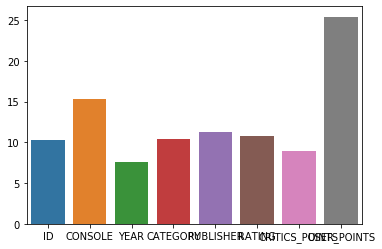

In [169]:
sns.barplot(x=train_df.columns[:-1], y = model.feature_importances_)

In [170]:
model.get_best_score()

{'learn': {'Jiten': 0.08846563372293526},
 'validation': {'Jiten': 0.21453645127671214}}

In [171]:
model.best_iteration_

6667

In [177]:
pred = model.predict(X_test)

print("RMSE ERROR == ",np.sqrt(mean_squared_error(inv_boxcox(y_test,0.27),inv_boxcox(pred,0.27))))

RMSE ERROR ==  1.6338228221642215


In [173]:
test_df.dtypes

ID                  int64
CONSOLE            object
YEAR                int64
CATEGORY           object
PUBLISHER          object
RATING             object
CRITICS_POINTS    float64
USER_POINTS       float64
dtype: object

In [176]:
submission = pd.DataFrame()

submission["SalesInMillions"] = inv_boxcox(model.predict(test_df),0.27)

submission.head()

submission.to_csv("sub.csv",index = False)

In [175]:
submission.head()

,SalesInMillions
0,1.672469
1,1.991664
2,4.589158
3,2.328596
4,1.527706
